--- Generating plot for Subject S1 with Per-Trial Standardization ---


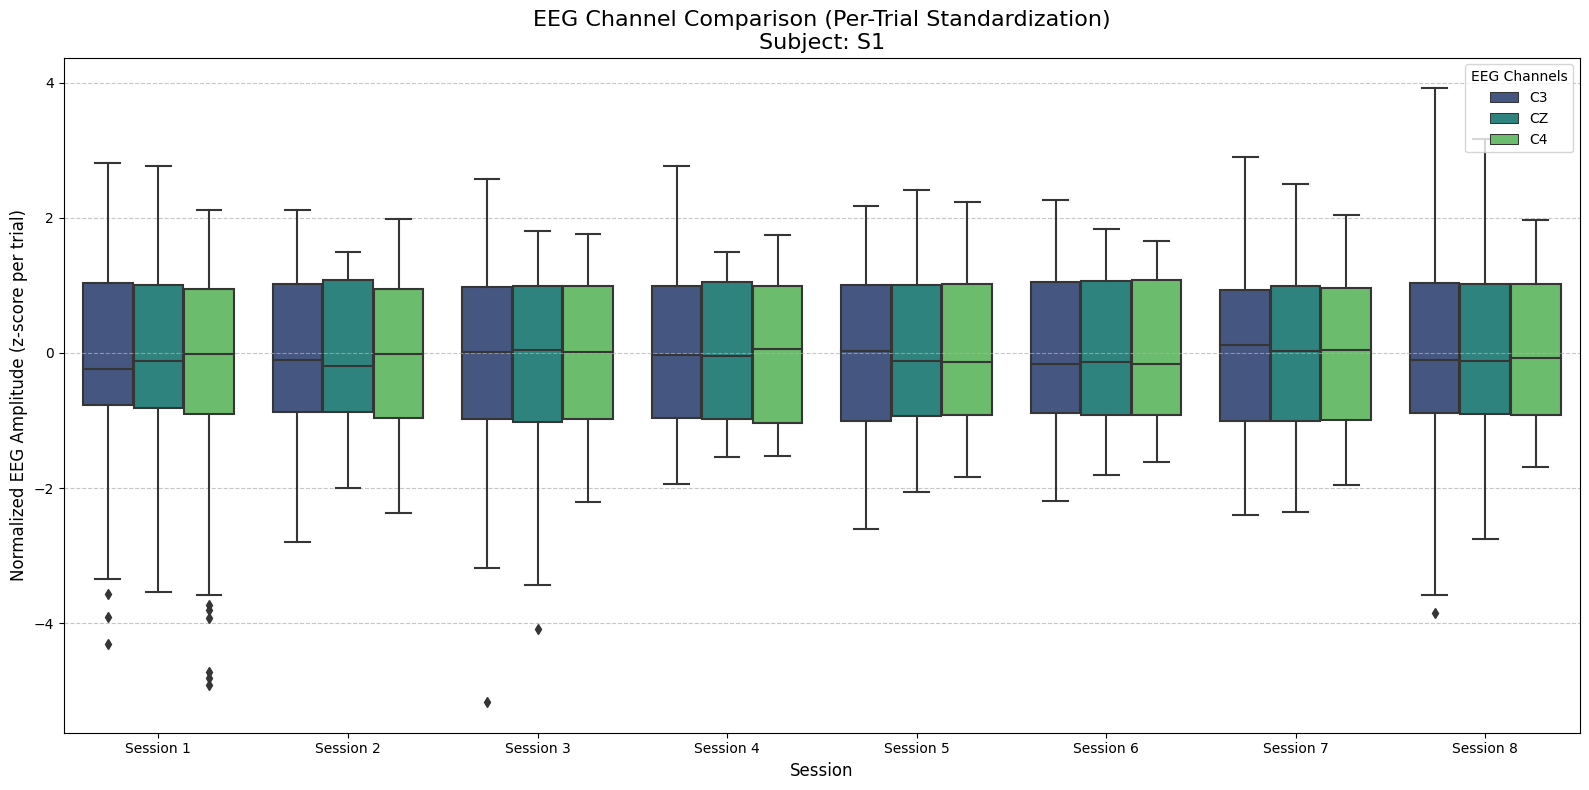

--- Generating plot for Subject S2 with Per-Trial Standardization ---


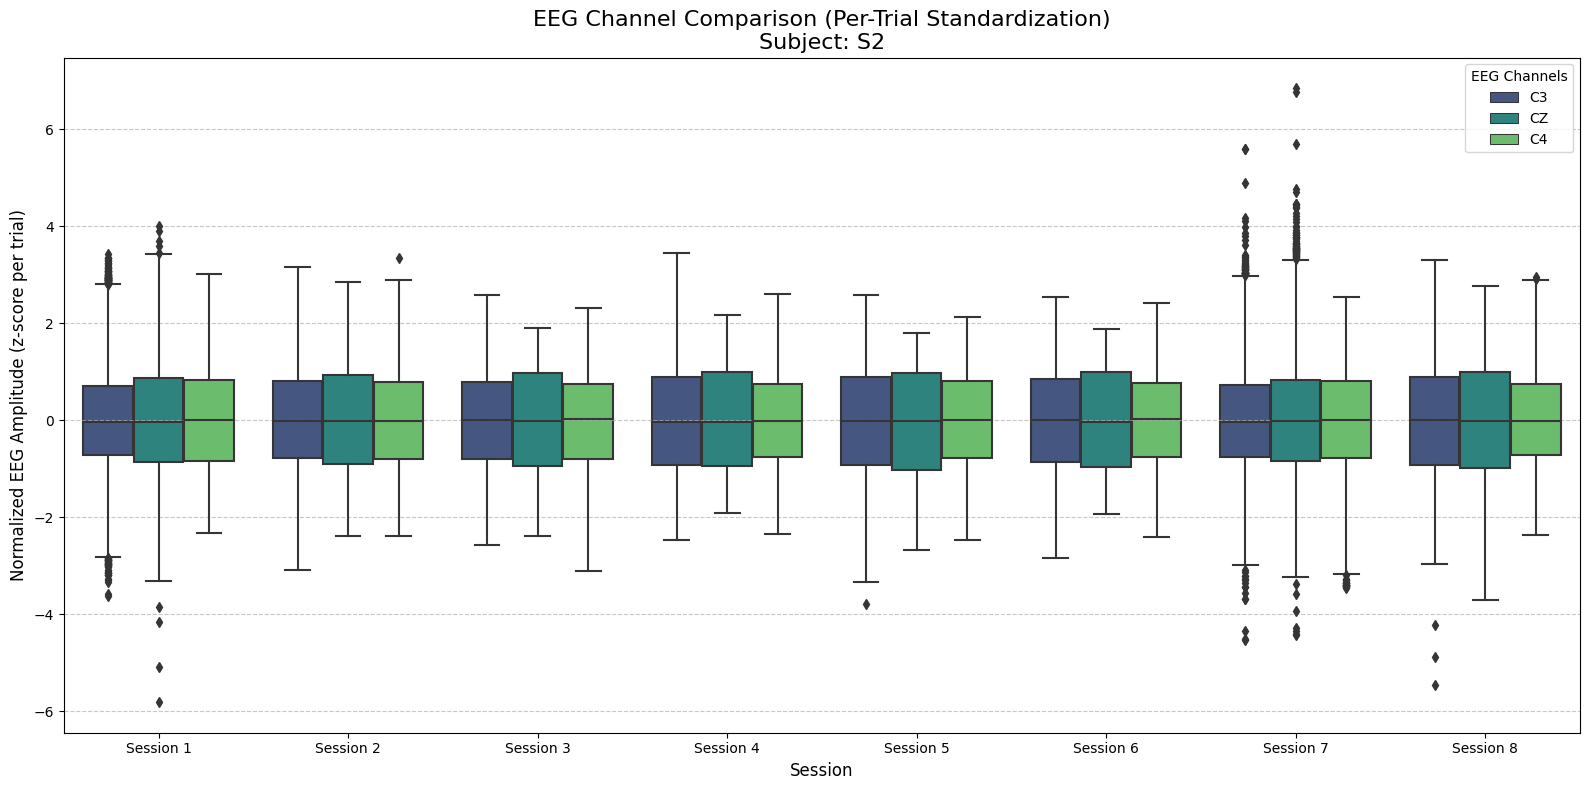

--- Generating plot for Subject S3 with Per-Trial Standardization ---


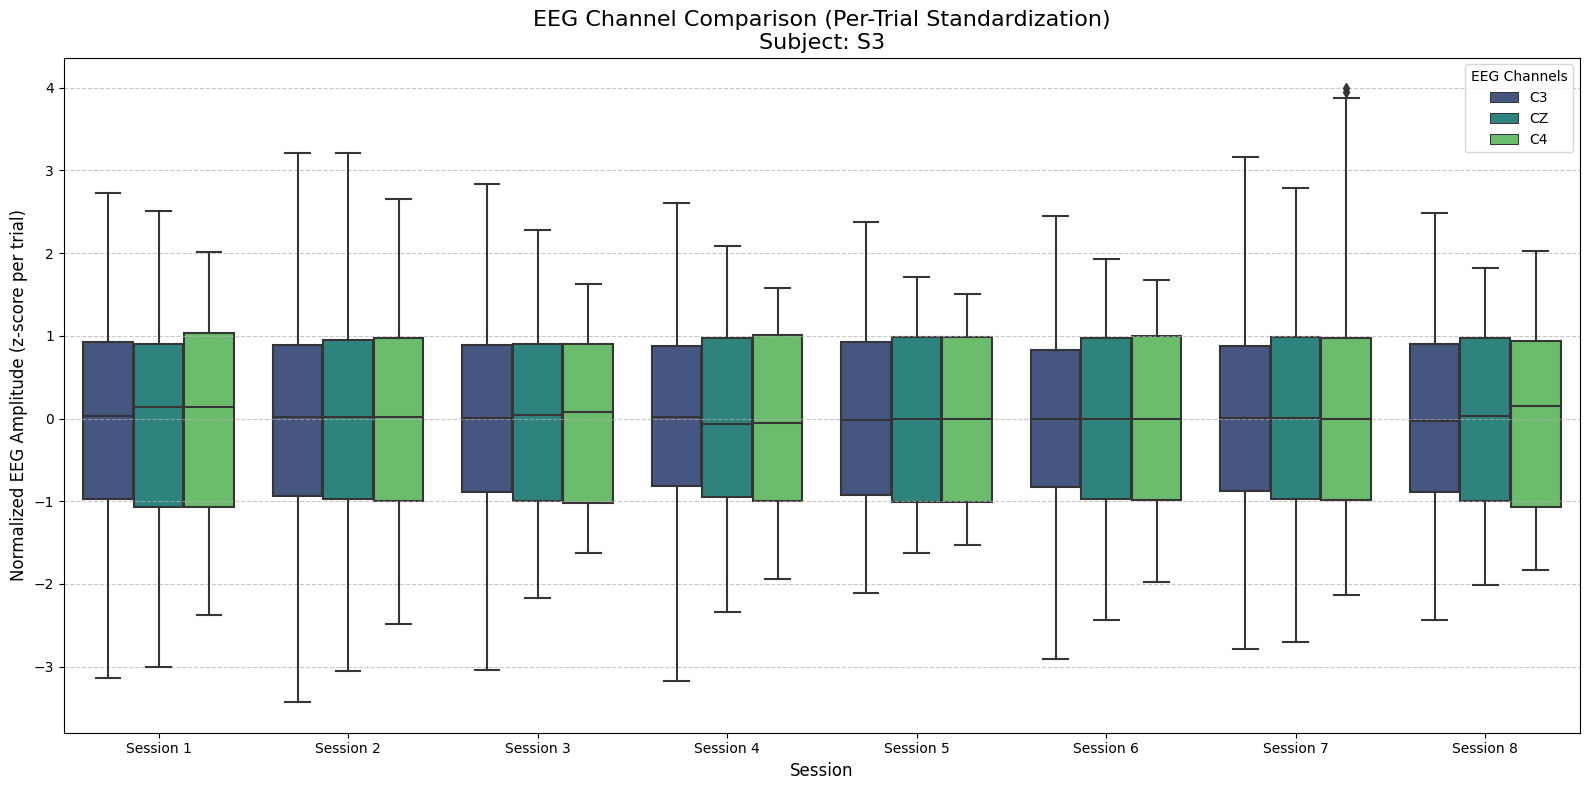

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
BASE_PATH = "/kaggle/input/mtcaic3"
TASK = "MI"
EEG_CHANNELS = ['C3', 'CZ', 'C4'] # Channels to use and plot

# --- NEW: Function to normalize a single trial by its own stats ---
def normalize_per_trial(trial_data):
    """
    Applies z-score normalization to a single trial using its own mean and standard deviation.
    """
    normalized_trial = trial_data.copy()
    
    # Calculate mean and std for each channel within this specific trial
    trial_mean = trial_data[EEG_CHANNELS].mean()
    trial_std = trial_data[EEG_CHANNELS].std()
    
    for channel in EEG_CHANNELS:
        # Avoid division by zero for a flat-line or constant signal trial
        if trial_std[channel] < 1e-8:
            normalized_trial[channel] = 0.0
        else:
            normalized_trial[channel] = (trial_data[channel] - trial_mean[channel]) / trial_std[channel]
            
    return normalized_trial

# --- REWRITTEN FUNCTION for Per-Trial Standardization Visualization ---
def plot_sessions_per_trial_standardization(subject_id, base_path=BASE_PATH, task=TASK):
    """
    Generates box plots for sessions where each trial has been individually standardized.
    NOTE: This is for visualizing the result of a preprocessing step, not for finding
          outlier sessions based on amplitude.
    """
    if not subject_id.startswith('S'):
        subject_id = 'S' + str(subject_id)
    
    subject_path = os.path.join(base_path, task, "train", subject_id)
    if not os.path.exists(subject_path):
        print(f"Error: Subject {subject_id} not found.")
        return
        
    session_dirs = sorted([d for d in os.listdir(subject_path) if d.isdigit()], key=int)
    if not session_dirs:
        print(f"No sessions found for subject {subject_id}")
        return

    all_normalized_trials = []
    samples_per_trial = 2250  # For MI task

    # --- Part 1: Loop, load, and apply per-trial normalization ---
    for session in session_dirs:
        session_path = os.path.join(subject_path, session, "EEGdata.csv")
        df = pd.read_csv(session_path)
        
        # Process each trial within the session
        for trial_idx in range(10): # 10 trials per session
            start_idx = trial_idx * samples_per_trial
            end_idx = start_idx + samples_per_trial
            trial_data = df.iloc[start_idx:end_idx]
            
            # Apply per-trial normalization
            normalized_trial = normalize_per_trial(trial_data[EEG_CHANNELS])
            
            normalized_trial['Session'] = f"Session {session}"
            all_normalized_trials.append(normalized_trial)
            
    # --- Part 2: Plotting the result ---
    # The statistical comparison is removed as it's no longer meaningful.
    print(f"--- Generating plot for Subject {subject_id} with Per-Trial Standardization ---")

    combined_df = pd.concat(all_normalized_trials)
    melted_df = combined_df.melt(id_vars=['Session'], value_vars=EEG_CHANNELS,
                                 var_name='Channel', value_name='Amplitude')
    
    plt.figure(figsize=(16, 8))
    sns.boxplot(x='Session', y='Amplitude', hue='Channel', data=melted_df, palette="viridis")
    
    # Update title to reflect the new normalization method
    plt.title(f"EEG Channel Comparison (Per-Trial Standardization)\nSubject: {subject_id}", fontsize=16)
    
    plt.xlabel("Session", fontsize=12)
    plt.ylabel("Normalized EEG Amplitude (z-score per trial)", fontsize=12)
    plt.legend(title='EEG Channels', loc='upper right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


# --- Example Usage ---
if __name__ == "__main__":
    # We run the combined plotting and analysis function for all subjects
    for i in range(1, 31): # Running for first 3 subjects as an example
        plot_sessions_per_trial_standardization(f"S{i}")

In [2]:
import os
import pandas as pd
import numpy as np
from scipy.stats import kurtosis

# --- Configuration ---
BASE_PATH = "/kaggle/input/mtcaic3"
TASK = "MI"
EEG_CHANNELS = ['C3', 'CZ', 'C4'] 
SAMPLES_PER_TRIAL_MI = 2250

def find_outlier_sessions_by_kurtosis(subject_id, base_path=BASE_PATH, task=TASK, iqr_multiplier=1.5):
    """
    Identifies outlier sessions based on the average kurtosis of their trials.
    High kurtosis often indicates spiky noise and artifacts.
    """
    if not subject_id.startswith('S'):
        subject_id = 'S' + str(subject_id)
        
    subject_path = os.path.join(base_path, task, "train", subject_id)
    if not os.path.exists(subject_path):
        print(f"Error: Subject {subject_id} not found.")
        return {}

    session_dirs = sorted([d for d in os.listdir(subject_path) if d.isdigit()], key=int)
    if not session_dirs:
        return {}

    session_kurtosis_scores = {}

    # --- Part 1: Calculate the average kurtosis for each session ---
    for session in session_dirs:
        session_path = os.path.join(subject_path, session, "EEGdata.csv")
        df = pd.read_csv(session_path)
        
        trial_kurtosis_values = []
        for trial_idx in range(10):  # 10 trials per session
            start_idx = trial_idx * SAMPLES_PER_TRIAL_MI
            end_idx = start_idx + SAMPLES_PER_TRIAL_MI
            trial_data = df.iloc[start_idx:end_idx]
            
            # Calculate Fisher kurtosis (normal is 0) for each channel in the trial
            # and average them to get a single score for the trial's "spikiness".
            kurt = np.mean(kurtosis(trial_data[EEG_CHANNELS], fisher=True, axis=0))
            trial_kurtosis_values.append(kurt)
            
        # The score for the session is the average kurtosis across its 10 trials
        session_kurtosis_scores[session] = np.mean(trial_kurtosis_values)

    # --- Part 2: Use the IQR method on the session kurtosis scores ---
    flagged_sessions = {}
    
    scores = list(session_kurtosis_scores.values())
    sessions = list(session_kurtosis_scores.keys())
    
    # Calculate IQR bounds for kurtosis. We mainly care about HIGH kurtosis.
    q1, q3 = np.percentile(scores, [25, 75])
    iqr = q3 - q1
    upper_bound = q3 + iqr_multiplier * iqr
    
    print(f"--- Kurtosis Analysis for Subject {subject_id} ---")
    print(f"Kurtosis Upper Bound (Threshold for noisy sessions): {upper_bound:.2f}")

    for i, session in enumerate(sessions):
        if scores[i] > upper_bound:
            reason = f"Session has abnormally high average trial kurtosis ({scores[i]:.2f}), indicating spiky noise."
            flagged_sessions.setdefault(session, []).append(reason)

    # --- Part 3: Reporting ---
    print("\n--- Flagged Sessions Report (Kurtosis Method) ---")
    if flagged_sessions:
        for session, reasons in sorted(flagged_sessions.items()):
            print(f"  Session {session} is flagged:")
            for reason in reasons:
                print(f"    - {reason}")
    else:
        print("  No anomalously noisy sessions detected based on kurtosis.")
    print("-" * 50 + "\n")
    
    return flagged_sessions

# --- Example Usage ---
if __name__ == "__main__":
    # We can now run this analysis for our subjects.
    for i in range(1, 31):
        find_outlier_sessions_by_kurtosis(f"S{i}")

--- Kurtosis Analysis for Subject S1 ---
Kurtosis Upper Bound (Threshold for noisy sessions): -1.37

--- Flagged Sessions Report (Kurtosis Method) ---
  Session 1 is flagged:
    - Session has abnormally high average trial kurtosis (-1.26), indicating spiky noise.
--------------------------------------------------

--- Kurtosis Analysis for Subject S2 ---
Kurtosis Upper Bound (Threshold for noisy sessions): -0.60

--- Flagged Sessions Report (Kurtosis Method) ---
  Session 7 is flagged:
    - Session has abnormally high average trial kurtosis (-0.37), indicating spiky noise.
--------------------------------------------------

--- Kurtosis Analysis for Subject S3 ---
Kurtosis Upper Bound (Threshold for noisy sessions): -1.18

--- Flagged Sessions Report (Kurtosis Method) ---
  No anomalously noisy sessions detected based on kurtosis.
--------------------------------------------------

--- Kurtosis Analysis for Subject S4 ---
Kurtosis Upper Bound (Threshold for noisy sessions): -1.06

--

In [4]:
import os
import pandas as pd
import numpy as np
from scipy.signal import welch

# --- Configuration ---
BASE_PATH = "/kaggle/input/mtcaic3"
TASK = "MI"
EEG_CHANNELS = ['C3', 'CZ', 'C4'] 
SAMPLING_RATE = 250  # Hz, from dataset description
SAMPLES_PER_TRIAL_MI = 2250

# --- Frequency Band Definitions ---
# We define bands that are often associated with noise.
FREQ_BANDS = {
    "low_freq_drift": (1, 4),    # For slow drift, sweat artifacts
    "high_freq_muscle": (30, 60) # For EMG/muscle artifacts
}

def find_outlier_sessions_by_psd(subject_id, base_path=BASE_PATH, task=TASK, iqr_multiplier=1.5):
    """
    Identifies outlier sessions by analyzing the power in specific frequency bands.
    Abnormal power in low or high frequencies can indicate noise.
    """
    if not subject_id.startswith('S'):
        subject_id = 'S' + str(subject_id)
        
    subject_path = os.path.join(base_path, task, "train", subject_id)
    if not os.path.exists(subject_path):
        print(f"Error: Subject {subject_id} not found.")
        return {}

    session_dirs = sorted([d for d in os.listdir(subject_path) if d.isdigit()], key=int)
    if not session_dirs:
        return {}

    # This dictionary will store the final power scores for each session.
    # Structure: {session: {"low_freq_drift": score, "high_freq_muscle": score}}
    session_power_scores = {}

    # --- Part 1: Calculate power scores for each session ---
    for session in session_dirs:
        session_path = os.path.join(subject_path, session, "EEGdata.csv")
        df = pd.read_csv(session_path)
        
        # Store power values for each trial to be averaged later
        session_band_powers = {band: [] for band in FREQ_BANDS}
        
        for trial_idx in range(10):
            start_idx = trial_idx * SAMPLES_PER_TRIAL_MI
            end_idx = start_idx + SAMPLES_PER_TRIAL_MI
            # We process all specified EEG channels for the trial at once
            trial_data = df.iloc[start_idx:end_idx][EEG_CHANNELS]
            
            # Calculate PSD using Welch's method
            # nperseg: length of each segment. A longer segment gives better frequency resolution.
            freqs, psd = welch(trial_data, fs=SAMPLING_RATE, nperseg=SAMPLING_RATE, axis=0)
            
            # Calculate average power in each defined band for this trial
            for band_name, (low_freq, high_freq) in FREQ_BANDS.items():
                freq_mask = (freqs >= low_freq) & (freqs <= high_freq)
                # We average the power across the frequencies in the band, and also across channels
                avg_power = np.mean(psd[freq_mask, :])
                session_band_powers[band_name].append(avg_power)
        
        # The score for the session is the average of its trial powers for each band
        session_power_scores[session] = {
            band: np.mean(powers) for band, powers in session_band_powers.items()
        }

    # --- Part 2: Use IQR to find outlier sessions for each noise band ---
    flagged_sessions = {}
    
    print(f"--- PSD Analysis for Subject {subject_id} ---")

    for band_name in FREQ_BANDS.keys():
        scores = [session_power_scores[s][band_name] for s in session_dirs]
        
        # Calculate IQR bounds. We only care about abnormally HIGH power.
        q1, q3 = np.percentile(scores, [25, 75])
        iqr = q3 - q1
        upper_bound = q3 + iqr_multiplier * iqr
        
        print(f"Power Upper Bound for '{band_name}' band: {upper_bound:.4g}")

        for i, session in enumerate(session_dirs):
            if scores[i] > upper_bound:
                reason = f"Session has high power in '{band_name}' band (score: {scores[i]:.4g})"
                flagged_sessions.setdefault(session, []).append(reason)
    
    # --- Part 3: Reporting ---
    print("\n--- Flagged Sessions Report (PSD Method) ---")
    if flagged_sessions:
        for session, reasons in sorted(flagged_sessions.items()):
            print(f"  Session {session} is flagged:")
            for reason in reasons:
                print(f"    - {reason}")
    else:
        print("  No anomalously noisy sessions detected based on frequency power.")
    print("-" * 50 + "\n")
    
    return flagged_sessions

# --- Example Usage ---
if __name__ == "__main__":
    # Let's run the analysis for the first few subjects to see it in action.
    for i in range(1, 31):
        find_outlier_sessions_by_psd(f"S{i}")

--- PSD Analysis for Subject S1 ---
Power Upper Bound for 'low_freq_drift' band: 1.114e+04
Power Upper Bound for 'high_freq_muscle' band: 2.578e+05

--- Flagged Sessions Report (PSD Method) ---
  Session 7 is flagged:
    - Session has high power in 'low_freq_drift' band (score: 1.267e+04)
--------------------------------------------------

--- PSD Analysis for Subject S2 ---
Power Upper Bound for 'low_freq_drift' band: 33.95
Power Upper Bound for 'high_freq_muscle' band: 923.6

--- Flagged Sessions Report (PSD Method) ---
  Session 1 is flagged:
    - Session has high power in 'low_freq_drift' band (score: 87.32)
--------------------------------------------------

--- PSD Analysis for Subject S3 ---
Power Upper Bound for 'low_freq_drift' band: 1.379e+04
Power Upper Bound for 'high_freq_muscle' band: 7.297e+04

--- Flagged Sessions Report (PSD Method) ---
  Session 7 is flagged:
    - Session has high power in 'low_freq_drift' band (score: 1.608e+04)
    - Session has high power in 'hi

In [5]:
import os
import pandas as pd
import numpy as np
from scipy.stats import kurtosis
from scipy.signal import welch

# --- Master Configuration ---
BASE_PATH = "/kaggle/input/mtcaic3"
TASK = "MI"
EEG_CHANNELS = ['C3', 'CZ', 'C4'] 
SAMPLING_RATE = 250
SAMPLES_PER_TRIAL_MI = 2250
IQR_MULTIPLIER = 1.5 # Can be tuned (e.g., 2.0 for less aggressive filtering)

# --- Frequency Band Definitions for PSD Analysis ---
FREQ_BANDS = {
    "low_freq_drift": (1, 4),
    "high_freq_muscle": (30, 60)
}

# --- Method 1: Kurtosis Analysis Function ---
def find_outlier_sessions_by_kurtosis(subject_id, base_path, task):
    subject_path = os.path.join(base_path, task, "train", subject_id)
    if not os.path.exists(subject_path): return {}
    session_dirs = sorted([d for d in os.listdir(subject_path) if d.isdigit()], key=int)
    if not session_dirs: return {}
    
    session_kurtosis_scores = {}
    for session in session_dirs:
        df = pd.read_csv(os.path.join(subject_path, session, "EEGdata.csv"))
        trial_kurts = [np.mean(kurtosis(df.iloc[i*SAMPLES_PER_TRIAL_MI:(i+1)*SAMPLES_PER_TRIAL_MI][EEG_CHANNELS], fisher=True, axis=0)) for i in range(10)]
        session_kurtosis_scores[session] = np.mean(trial_kurts)
        
    scores = list(session_kurtosis_scores.values())
    q1, q3 = np.percentile(scores, [25, 75])
    upper_bound = q3 + IQR_MULTIPLIER * (q3 - q1)
    
    return {int(s) for s, score in session_kurtosis_scores.items() if score > upper_bound}

# --- Method 2: PSD Analysis Function ---
def find_outlier_sessions_by_psd(subject_id, base_path, task):
    subject_path = os.path.join(base_path, task, "train", subject_id)
    if not os.path.exists(subject_path): return {}
    session_dirs = sorted([d for d in os.listdir(subject_path) if d.isdigit()], key=int)
    if not session_dirs: return {}

    session_power_scores = {}
    for session in session_dirs:
        df = pd.read_csv(os.path.join(subject_path, session, "EEGdata.csv"))
        session_band_powers = {band: [] for band in FREQ_BANDS}
        for i in range(10):
            trial_data = df.iloc[i*SAMPLES_PER_TRIAL_MI:(i+1)*SAMPLES_PER_TRIAL_MI][EEG_CHANNELS]
            freqs, psd = welch(trial_data, fs=SAMPLING_RATE, nperseg=SAMPLING_RATE, axis=0)
            for band, (low, high) in FREQ_BANDS.items():
                mask = (freqs >= low) & (freqs <= high)
                session_band_powers[band].append(np.mean(psd[mask, :]))
        session_power_scores[session] = {b: np.mean(p) for b, p in session_band_powers.items()}
    
    flagged_sessions = set()
    for band in FREQ_BANDS.keys():
        scores = [session_power_scores[s][band] for s in session_dirs]
        q1, q3 = np.percentile(scores, [25, 75])
        upper_bound = q3 + IQR_MULTIPLIER * (q3 - q1)
        for s, score in zip(session_dirs, scores):
            if score > upper_bound:
                flagged_sessions.add(int(s))
    return flagged_sessions

# --- Function to build the benchmark from clean training data ---
def get_global_benchmark_bounds(discarded_sessions, base_path, task):
    print("\n--- Building Global Benchmark from Clean Training Data ---")
    all_good_kurtosis = []
    all_good_powers = {band: [] for band in FREQ_BANDS}
    
    train_path = os.path.join(base_path, task, "train")
    for subject_id in sorted(os.listdir(train_path)):
        if not subject_id.startswith('S'): continue
        subject_path = os.path.join(train_path, subject_id)
        for session in os.listdir(subject_path):
            if not session.isdigit() or int(session) in discarded_sessions.get(subject_id, []):
                continue
            df = pd.read_csv(os.path.join(subject_path, session, "EEGdata.csv"))
            
            # Kurtosis
            trial_kurts = [np.mean(kurtosis(df.iloc[i*SAMPLES_PER_TRIAL_MI:(i+1)*SAMPLES_PER_TRIAL_MI][EEG_CHANNELS], fisher=True, axis=0)) for i in range(10)]
            all_good_kurtosis.append(np.mean(trial_kurts))
            
            # PSD
            for i in range(10):
                trial_data = df.iloc[i*SAMPLES_PER_TRIAL_MI:(i+1)*SAMPLES_PER_TRIAL_MI][EEG_CHANNELS]
                freqs, psd = welch(trial_data, fs=SAMPLING_RATE, nperseg=SAMPLING_RATE, axis=0)
                for band, (low, high) in FREQ_BANDS.items():
                    mask = (freqs >= low) & (freqs <= high)
                    all_good_powers[band].append(np.mean(psd[mask, :]))

    global_bounds = {}
    q1_k, q3_k = np.percentile(all_good_kurtosis, [25, 75])
    global_bounds['kurtosis'] = [q1_k - IQR_MULTIPLIER * (q3_k - q1_k), q3_k + IQR_MULTIPLIER * (q3_k - q1_k)]
    
    for band in FREQ_BANDS.keys():
        q1_p, q3_p = np.percentile(all_good_powers[band], [25, 75])
        global_bounds[band] = [q1_p - IQR_MULTIPLIER * (q3_p - q1_p), q3_p + IQR_MULTIPLIER * (q3_p - q1_p)]
        
    print("Benchmark built successfully.")
    return global_bounds

# --- Function to analyze validation/test data against the benchmark ---
def analyze_val_test_data(df, dataset_name, global_bounds, base_path, task):
    print(f"\n--- Analyzing {dataset_name.upper()} Data against Global Benchmark ---")
    flagged_sessions = {}
    
    unique_sessions = df[['subject_id', 'trial_session']].drop_duplicates()
    for _, row in unique_sessions.iterrows():
        subject_id = row['subject_id']
        session_num = str(row['trial_session'])
        eeg_path = f"{base_path}/{task}/{dataset_name}/{subject_id}/{session_num}/EEGdata.csv"
        if not os.path.exists(eeg_path): continue
        
        session_data = pd.read_csv(eeg_path)
        
        # Calculate stats for this session
        trial_kurts = [np.mean(kurtosis(session_data.iloc[i*SAMPLES_PER_TRIAL_MI:(i+1)*SAMPLES_PER_TRIAL_MI][EEG_CHANNELS], fisher=True, axis=0)) for i in range(10)]
        session_kurtosis = np.mean(trial_kurts)
        
        trial_powers = {band: [] for band in FREQ_BANDS}
        for i in range(10):
            trial_data = session_data.iloc[i*SAMPLES_PER_TRIAL_MI:(i+1)*SAMPLES_PER_TRIAL_MI][EEG_CHANNELS]
            freqs, psd = welch(trial_data, fs=SAMPLING_RATE, nperseg=SAMPLING_RATE, axis=0)
            for band, (low, high) in FREQ_BANDS.items():
                mask = (freqs >= low) & (freqs <= high)
                trial_powers[band].append(np.mean(psd[mask,:]))
        session_powers = {band: np.mean(p) for band, p in trial_powers.items()}
        
        # Compare to benchmark
        session_id_str = f"{subject_id}_Session{session_num}"
        if not (global_bounds['kurtosis'][0] <= session_kurtosis <= global_bounds['kurtosis'][1]):
            flagged_sessions.setdefault(session_id_str, []).append(f"Kurtosis ({session_kurtosis:.2f}) outside normal range.")
        for band in FREQ_BANDS.keys():
            if not (global_bounds[band][0] <= session_powers[band] <= global_bounds[band][1]):
                flagged_sessions.setdefault(session_id_str, []).append(f"Power in '{band}' ({session_powers[band]:.4g}) outside normal range.")

    if flagged_sessions:
        for session_id, reasons in flagged_sessions.items():
            print(f"  - Session {session_id} is flagged as anomalous:")
            for reason in reasons: print(f"    - {reason}")
    else:
        print("  No anomalous sessions detected in this dataset.")

# --- Main Execution Block ---
if __name__ == "__main__":
    # Step 1: Analyze training data and generate a comprehensive discard list
    print("--- STEP 1: Analyzing Training Data to Find Outlier Sessions ---")
    DISCARDED_SESSIONS = {}
    for i in range(1, 31):
        subject_id = f"S{i}"
        flagged_by_kurt = find_outlier_sessions_by_kurtosis(subject_id, BASE_PATH, TASK)
        flagged_by_psd = find_outlier_sessions_by_psd(subject_id, BASE_PATH, TASK)
        
        # Combine results from both methods using a set union
        all_flagged = flagged_by_kurt.union(flagged_by_psd)
        
        if all_flagged:
            DISCARDED_SESSIONS[subject_id] = sorted(list(all_flagged))
            
    print("\n--- FINAL DISCARD LIST (Training Set) ---")
    if DISCARDED_SESSIONS:
        for subject, sessions in DISCARDED_SESSIONS.items():
            print(f"  - Subject {subject}: Discard sessions {sessions}")
    else:
        print("  No sessions were flagged for discarding.")
    
    # Step 2: Build the global benchmark using only the clean training data
    global_bounds = get_global_benchmark_bounds(DISCARDED_SESSIONS, BASE_PATH, TASK)
    
    # Step 3: Analyze validation and test sets
    validation_df = pd.read_csv(os.path.join(BASE_PATH, 'validation.csv'))
    test_df = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))
    
    analyze_val_test_data(validation_df, "validation", global_bounds, BASE_PATH, TASK)
    analyze_val_test_data(test_df, "test", global_bounds, BASE_PATH, TASK)

--- STEP 1: Analyzing Training Data to Find Outlier Sessions ---

--- FINAL DISCARD LIST (Training Set) ---
  - Subject S1: Discard sessions [1, 7]
  - Subject S2: Discard sessions [1, 7]
  - Subject S3: Discard sessions [7, 8]
  - Subject S4: Discard sessions [2]
  - Subject S5: Discard sessions [5, 6]
  - Subject S6: Discard sessions [3]
  - Subject S7: Discard sessions [3]
  - Subject S8: Discard sessions [2, 3]
  - Subject S9: Discard sessions [6, 8]
  - Subject S10: Discard sessions [1]
  - Subject S11: Discard sessions [2, 4]
  - Subject S12: Discard sessions [1]
  - Subject S14: Discard sessions [1, 2, 3]
  - Subject S15: Discard sessions [7]
  - Subject S16: Discard sessions [4]
  - Subject S17: Discard sessions [4, 6]
  - Subject S18: Discard sessions [1, 2]
  - Subject S19: Discard sessions [1, 4]
  - Subject S21: Discard sessions [1]
  - Subject S23: Discard sessions [5]
  - Subject S24: Discard sessions [1, 3]
  - Subject S25: Discard sessions [1]
  - Subject S26: Discard s

Loading and preparing MI trial index...
Analyzing 2400 MI trials to find active windows...


Analyzing Trials: 100%|██████████| 2400/2400 [08:18<00:00,  4.81it/s]



===== Analysis Complete =====
The single BEST individual window is 5.75s - 6.75s (Duration: 1.0s)
This window alone captures the correct pattern in 1290 of 2400 trials (53.75%).


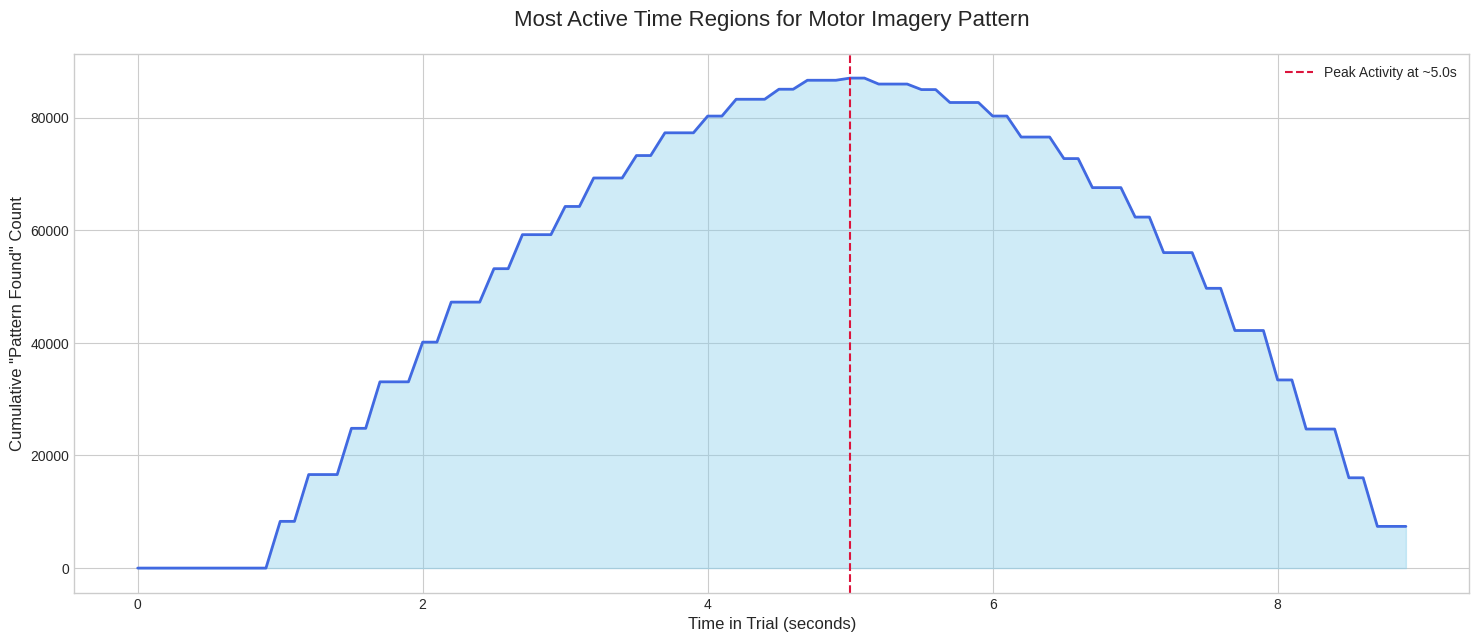

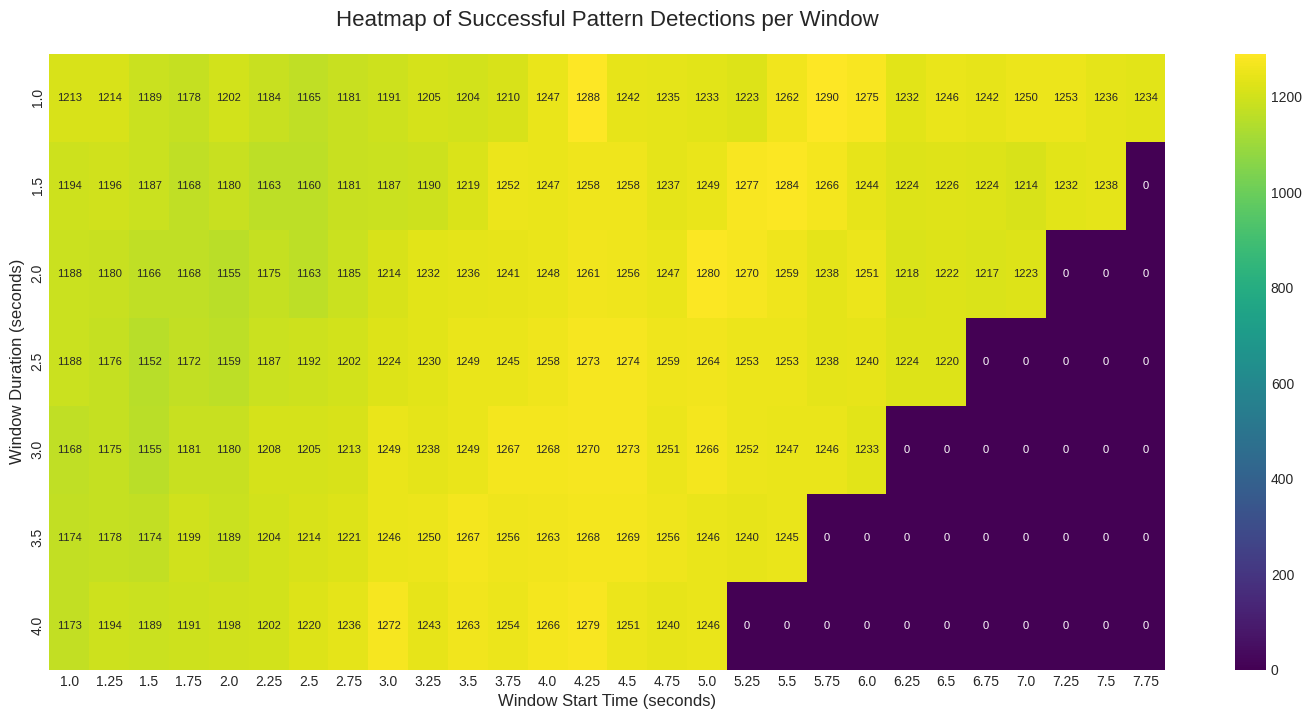

In [1]:
import os
import numpy as np
import pandas as pd
from scipy.signal import welch
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# --- Configuration ---
BASE_PATH = '/kaggle/input/mtcaic3'  # IMPORTANT: Set this to your dataset path
SAMPLING_RATE = 250  # Hz
MU_ALPHA_BAND = [8, 13]  # Frequency band of interest for motor imagery
BASELINE_WINDOW = [0.0, 1.0] # Use the first second of the trial as the baseline

# Suppress pandas performance warnings about fragmentation
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# --- Helper Functions (Identical to previous script) ---
def load_trial_data(row, base_path='.'):
    """Loads the raw EEG data for a single trial."""
    id_num = row['id']
    if 1 <= id_num <= 4800:
        dataset_split = 'train'
    else:
        dataset_split = 'validation'
    eeg_path = os.path.join(base_path, row['task'], dataset_split, row['subject_id'], str(row['trial_session']), 'EEGdata.csv')
    if not os.path.exists(eeg_path):
        return None
    eeg_data = pd.read_csv(eeg_path)
    samples_per_trial = 2250 # MI specific
    trial_num = int(row['trial'])
    start_idx = (trial_num - 1) * samples_per_trial
    end_idx = start_idx + samples_per_trial
    return eeg_data.iloc[start_idx:end_idx]

def calculate_band_power(data, band, fs):
    """Calculates the average power in a specific frequency band using Welch's method."""
    win_len = min(len(data), fs)
    if win_len == 0: return 0
    freqs, psd = welch(data, fs, nperseg=win_len)
    idx_band = np.logical_and(freqs >= band[0], freqs <= band[1])
    if not np.any(idx_band): return 0
    return np.mean(psd[idx_band])

# --- Main Analysis Script ---

print("Loading and preparing MI trial index...")
try:
    train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
    mi_trials_df = train_df[train_df['task'] == 'MI'].reset_index(drop=True)
except FileNotFoundError:
    print(f"ERROR: Could not find train.csv at {BASE_PATH}. Please check BASE_PATH.")
    exit()

# Define the grid of windows to search
durations_to_test = np.arange(1.0, 4.5, 0.5) # Durations from 1.0s to 4.0s
start_points_to_test = np.arange(1.0, 8.0, 0.25) # Start points from 1.0s to 7.75s

# Create a heatmap to store the counts for each window
heatmap_counts = pd.DataFrame(0, index=durations_to_test, columns=start_points_to_test)

print(f"Analyzing {len(mi_trials_df)} MI trials to find active windows...")

for i, trial_info in tqdm(mi_trials_df.iterrows(), total=len(mi_trials_df), desc="Analyzing Trials"):
    trial_data = load_trial_data(trial_info, BASE_PATH)
    if trial_data is None or trial_data.empty:
        continue

    signal_c3, signal_c4 = trial_data['C3'].values, trial_data['C4'].values

    baseline_start_idx, baseline_end_idx = int(BASELINE_WINDOW[0] * SAMPLING_RATE), int(BASELINE_WINDOW[1] * SAMPLING_RATE)
    baseline_power_c3 = calculate_band_power(signal_c3[baseline_start_idx:baseline_end_idx], MU_ALPHA_BAND, SAMPLING_RATE)
    baseline_power_c4 = calculate_band_power(signal_c4[baseline_start_idx:baseline_end_idx], MU_ALPHA_BAND, SAMPLING_RATE)
    if baseline_power_c3 == 0 or baseline_power_c4 == 0:
        continue

    # Test every window, DO NOT break after first find
    for duration in durations_to_test:
        for start_point in start_points_to_test:
            end_point = start_point + duration
            if end_point > 9.0:
                continue

            window_start_idx, window_end_idx = int(start_point * SAMPLING_RATE), int(end_point * SAMPLING_RATE)
            window_power_c3 = calculate_band_power(signal_c3[window_start_idx:window_end_idx], MU_ALPHA_BAND, SAMPLING_RATE)
            window_power_c4 = calculate_band_power(signal_c4[window_start_idx:window_end_idx], MU_ALPHA_BAND, SAMPLING_RATE)
            
            erd_ratio_c3 = window_power_c3 / baseline_power_c3
            erd_ratio_c4 = window_power_c4 / baseline_power_c4
            
            if (trial_info['label'] == 'Left' and erd_ratio_c4 < erd_ratio_c3) or \
               (trial_info['label'] == 'Right' and erd_ratio_c3 < erd_ratio_c4):
                # Increment the count for this specific window
                heatmap_counts.loc[duration, start_point] += 1

# --- Aggregation and Visualization ---

# Create a 1D timeline to visualize the most active regions
timeline_counts = np.zeros(int(9.0 / 0.1)) # Bins of 0.1 seconds
for duration in heatmap_counts.index:
    for start_point in heatmap_counts.columns:
        count = heatmap_counts.loc[duration, start_point]
        start_bin = int(start_point / 0.1)
        end_bin = int((start_point + duration) / 0.1)
        if end_bin > len(timeline_counts):
            end_bin = len(timeline_counts)
        timeline_counts[start_bin:end_bin] += count

# Find the single best window from the heatmap
max_count = heatmap_counts.max().max()
best_start = heatmap_counts.max(axis=0).idxmax()
best_duration = heatmap_counts.idxmax(axis=0)[best_start]
best_window_percentage = (max_count / len(mi_trials_df)) * 100

print("\n===== Analysis Complete =====")
print(f"The single BEST individual window is {best_start:.2f}s - {best_start+best_duration:.2f}s (Duration: {best_duration:.1f}s)")
print(f"This window alone captures the correct pattern in {max_count} of {len(mi_trials_df)} trials ({best_window_percentage:.2f}%).")

# Plotting the 1D timeline
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax1 = plt.subplots(figsize=(18, 7))
time_axis = np.arange(0, 9.0, 0.1)
ax1.plot(time_axis, timeline_counts, color='royalblue', lw=2)
ax1.fill_between(time_axis, timeline_counts, color='skyblue', alpha=0.4)
ax1.set_title('Most Active Time Regions for Motor Imagery Pattern', fontsize=16, pad=20)
ax1.set_xlabel('Time in Trial (seconds)', fontsize=12)
ax1.set_ylabel('Cumulative "Pattern Found" Count', fontsize=12)
peak_time = time_axis[np.argmax(timeline_counts)]
ax1.axvline(x=peak_time, color='crimson', linestyle='--', label=f'Peak Activity at ~{peak_time:.1f}s')
ax1.legend()
ax1.grid(True)
plt.show()

# Plotting the 2D Heatmap
fig, ax2 = plt.subplots(figsize=(18, 8))
sns.heatmap(heatmap_counts, ax=ax2, cmap='viridis', annot=True, fmt=".0f", annot_kws={"size": 8})
ax2.set_title('Heatmap of Successful Pattern Detections per Window', fontsize=16, pad=20)
ax2.set_xlabel('Window Start Time (seconds)', fontsize=12)
ax2.set_ylabel('Window Duration (seconds)', fontsize=12)
plt.show()

In [2]:
import os
import numpy as np
import pandas as pd
from scipy.signal import welch
from tqdm import tqdm
from collections import defaultdict
import warnings

# --- Configuration ---
BASE_PATH = '/kaggle/input/mtcaic3'  # IMPORTANT: Set this to your dataset path
SAMPLING_RATE = 250  # Hz
MU_ALPHA_BAND = [8, 13]  # Frequency band of interest
BASELINE_WINDOW = [0.0, 1.0] # Baseline period

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# --- Helper Functions (Identical to previous script) ---
def load_trial_data(row, base_path='.'):
    """Loads the raw EEG data for a single trial."""
    id_num = row['id']
    if 1 <= id_num <= 4800:
        dataset_split = 'train'
    else:
        dataset_split = 'validation'
    eeg_path = os.path.join(base_path, row['task'], dataset_split, row['subject_id'], str(row['trial_session']), 'EEGdata.csv')
    if not os.path.exists(eeg_path): return None
    eeg_data = pd.read_csv(eeg_path)
    samples_per_trial = 2250 # MI specific
    trial_num = int(row['trial'])
    start_idx = (trial_num - 1) * samples_per_trial
    end_idx = start_idx + samples_per_trial
    return eeg_data.iloc[start_idx:end_idx]

def calculate_band_power(data, band, fs):
    """Calculates the average power in a specific frequency band."""
    win_len = min(len(data), fs)
    if win_len == 0: return 0
    freqs, psd = welch(data, fs, nperseg=win_len)
    idx_band = np.logical_and(freqs >= band[0], freqs <= band[1])
    if not np.any(idx_band): return 0
    return np.mean(psd[idx_band])

# --- Main Analysis Script ---

print("Loading and preparing MI trial index...")
try:
    train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
    mi_trials_df = train_df[train_df['task'] == 'MI'].reset_index(drop=True)
except FileNotFoundError:
    print(f"ERROR: Could not find train.csv at {BASE_PATH}.")
    exit()

# Define the grid of windows to test
durations = np.arange(1.0, 4.5, 0.5)
starts = np.arange(1.0, 8.0, 0.25)
all_possible_windows = [(s, d) for s in starts for d in durations if s + d <= 9.0]

# PHASE 1: Pre-computation - Find all successful windows for each trial
print("\nPHASE 1: Finding successful windows for each trial (this may take a few minutes)...")
trial_id_to_successful_windows = defaultdict(list)
all_successful_trials = set()

for i, trial_info in tqdm(mi_trials_df.iterrows(), total=len(mi_trials_df), desc="Analyzing Trials"):
    trial_data = load_trial_data(trial_info, BASE_PATH)
    if trial_data is None or trial_data.empty: continue
    
    signal_c3, signal_c4 = trial_data['C3'].values, trial_data['C4'].values
    baseline_start, baseline_end = int(BASELINE_WINDOW[0] * SAMPLING_RATE), int(BASELINE_WINDOW[1] * SAMPLING_RATE)
    baseline_power_c3 = calculate_band_power(signal_c3[baseline_start:baseline_end], MU_ALPHA_BAND, SAMPLING_RATE)
    baseline_power_c4 = calculate_band_power(signal_c4[baseline_start:baseline_end], MU_ALPHA_BAND, SAMPLING_RATE)
    if baseline_power_c3 == 0 or baseline_power_c4 == 0: continue

    for start_point, duration in all_possible_windows:
        end_point = start_point + duration
        win_start, win_end = int(start_point * SAMPLING_RATE), int(end_point * SAMPLING_RATE)
        win_power_c3 = calculate_band_power(signal_c3[win_start:win_end], MU_ALPHA_BAND, SAMPLING_RATE)
        win_power_c4 = calculate_band_power(signal_c4[win_start:win_end], MU_ALPHA_BAND, SAMPLING_RATE)
        
        erd_c3 = win_power_c3 / baseline_power_c3
        erd_c4 = win_power_c4 / baseline_power_c4
        
        if (trial_info['label'] == 'Left' and erd_c4 < erd_c3) or (trial_info['label'] == 'Right' and erd_c3 < erd_c4):
            trial_id_to_successful_windows[i].append((start_point, duration))
            all_successful_trials.add(i)

total_coverable_trials = len(all_successful_trials)
print(f"Phase 1 Complete. Found {total_coverable_trials} trials with at least one valid window.")

# PHASE 2: Greedy Algorithm to select the best set of windows
print("\nPHASE 2: Running Greedy Algorithm to find the optimal set of windows...")
selected_windows = []
covered_trials = set()

while len(covered_trials) < total_coverable_trials:
    best_window = None
    best_new_coverage = set()

    # Find the window that covers the most UNCOVERED trials
    for window in tqdm(all_possible_windows, desc=f"Finding best window #{len(selected_windows)+1}"):
        
        # Find which new trials this window covers
        current_coverage = set()
        for trial_id, successful_windows in trial_id_to_successful_windows.items():
            if trial_id not in covered_trials and window in successful_windows:
                current_coverage.add(trial_id)

        if len(current_coverage) > len(best_new_coverage):
            best_new_coverage = current_coverage
            best_window = window

    if best_window is None or len(best_new_coverage) == 0:
        print("No more windows can cover remaining trials. Stopping.")
        break
    
    # Add the best found window to our set
    selected_windows.append(best_window)
    covered_trials.update(best_new_coverage)
    
    start, dur = best_window
    coverage_perc = (len(covered_trials) / total_coverable_trials) * 100
    
    print(f"\n---> Selected Window #{len(selected_windows)}: {start:.2f}s - {start+dur:.2f}s (Duration: {dur:.1f}s)")
    print(f"      - It covered {len(best_new_coverage)} new trials.")
    print(f"      - Cumulative coverage is now {len(covered_trials)} / {total_coverable_trials} ({coverage_perc:.2f}%)")

    # Optional: Stop after a certain number of windows if desired
    if len(selected_windows) >= 5:
      print("\nStopping after finding 5 windows, as this is typically sufficient for a strong ensemble.")
      break


print("\n===== Greedy Selection Complete =====")
print("The following windows are recommended for your ensemble model, selected to maximize unique coverage:")
for i, (start, dur) in enumerate(selected_windows):
    print(f"  Model {i+1}: Window = {start:.2f}s - {start+dur:.2f}s (Duration: {dur:.1f}s)")

Loading and preparing MI trial index...

PHASE 1: Finding successful windows for each trial (this may take a few minutes)...


Analyzing Trials: 100%|██████████| 2400/2400 [07:26<00:00,  5.38it/s]


Phase 1 Complete. Found 2273 trials with at least one valid window.

PHASE 2: Running Greedy Algorithm to find the optimal set of windows...


Finding best window #1: 100%|██████████| 160/160 [00:01<00:00, 131.94it/s]



---> Selected Window #1: 5.75s - 6.75s (Duration: 1.0s)
      - It covered 1290 new trials.
      - Cumulative coverage is now 1290 / 2273 (56.75%)


Finding best window #2: 100%|██████████| 160/160 [00:00<00:00, 550.88it/s]



---> Selected Window #2: 1.25s - 2.25s (Duration: 1.0s)
      - It covered 369 new trials.
      - Cumulative coverage is now 1659 / 2273 (72.99%)


Finding best window #3: 100%|██████████| 160/160 [00:00<00:00, 1001.26it/s]



---> Selected Window #3: 7.25s - 8.25s (Duration: 1.0s)
      - It covered 181 new trials.
      - Cumulative coverage is now 1840 / 2273 (80.95%)


Finding best window #4: 100%|██████████| 160/160 [00:00<00:00, 1487.74it/s]



---> Selected Window #4: 4.25s - 5.25s (Duration: 1.0s)
      - It covered 110 new trials.
      - Cumulative coverage is now 1950 / 2273 (85.79%)


Finding best window #5: 100%|██████████| 160/160 [00:00<00:00, 2191.83it/s]


---> Selected Window #5: 2.75s - 3.75s (Duration: 1.0s)
      - It covered 75 new trials.
      - Cumulative coverage is now 2025 / 2273 (89.09%)

Stopping after finding 5 windows, as this is typically sufficient for a strong ensemble.

===== Greedy Selection Complete =====
The following windows are recommended for your ensemble model, selected to maximize unique coverage:
  Model 1: Window = 5.75s - 6.75s (Duration: 1.0s)
  Model 2: Window = 1.25s - 2.25s (Duration: 1.0s)
  Model 3: Window = 7.25s - 8.25s (Duration: 1.0s)
  Model 4: Window = 4.25s - 5.25s (Duration: 1.0s)
  Model 5: Window = 2.75s - 3.75s (Duration: 1.0s)


In [4]:
import os
import numpy as np
import pandas as pd
from scipy.signal import welch
from tqdm import tqdm
import warnings

# --- Configuration ---
BASE_PATH = '/kaggle/input/mtcaic3'  # IMPORTANT: Set this to your dataset path
SAMPLING_RATE = 250  # Hz
MU_ALPHA_BAND = [8, 13]  # Frequency band of interest for motor imagery
BASELINE_WINDOW = [0.0, 1.0] # Use the first second of the trial as the baseline

# Define the final, recommended windows for the ensemble
ENSEMBLE_WINDOWS = [
    {'start': 4.5, 'end': 5.5, 'name': 'Early Specialist'},
    {'start': 5.0, 'end': 6.0, 'name': 'pre-Peak Specialist'},
    {'start': 5.5, 'end': 6.5, 'name': 'centered'},
    {'start': 6.0, 'end': 7.0, 'name': 'post peak'},
    {'start': 6.5, 'end': 7.5, 'name': 'late'}
]

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# --- Helper Functions (Identical to previous script) ---
def load_trial_data(row, base_path='.'):
    """Loads the raw EEG data for a single trial."""
    id_num = row['id']
    if 1 <= id_num <= 4800:
        dataset_split = 'train'
    else:
        dataset_split = 'validation'
    eeg_path = os.path.join(base_path, row['task'], dataset_split, row['subject_id'], str(row['trial_session']), 'EEGdata.csv')
    if not os.path.exists(eeg_path): return None
    eeg_data = pd.read_csv(eeg_path)
    samples_per_trial = 2250 # MI specific
    trial_num = int(row['trial'])
    start_idx = (trial_num - 1) * samples_per_trial
    end_idx = start_idx + samples_per_trial
    return eeg_data.iloc[start_idx:end_idx]

def calculate_band_power(data, band, fs):
    """Calculates the average power in a specific frequency band."""
    win_len = min(len(data), fs)
    if win_len == 0: return 0
    freqs, psd = welch(data, fs, nperseg=win_len)
    idx_band = np.logical_and(freqs >= band[0], freqs <= band[1])
    if not np.any(idx_band): return 0
    return np.mean(psd[idx_band])

# --- Main Analysis Script ---

print("Loading and preparing MI trial index...")
try:
    train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
    mi_trials_df = train_df[train_df['task'] == 'MI'].reset_index(drop=True)
    total_trials = len(mi_trials_df)
except FileNotFoundError:
    print(f"ERROR: Could not find train.csv at {BASE_PATH}. Please check BASE_PATH.")
    exit()

print(f"Found {total_trials} MI trials to analyze.")

trials_covered_by_ensemble = 0

print("\n===== Calculating Total Coverage of the Final Ensemble =====")

for i, trial_info in tqdm(mi_trials_df.iterrows(), total=total_trials, desc="Processing Trials"):
    trial_data = load_trial_data(trial_info, BASE_PATH)
    if trial_data is None or trial_data.empty:
        total_trials -=1 # Adjust total if a file is missing/empty
        continue

    signal_c3, signal_c4 = trial_data['C3'].values, trial_data['C4'].values

    # Calculate Baseline Power (once per trial)
    baseline_start_idx, baseline_end_idx = int(BASELINE_WINDOW[0] * SAMPLING_RATE), int(BASELINE_WINDOW[1] * SAMPLING_RATE)
    baseline_power_c3 = calculate_band_power(signal_c3[baseline_start_idx:baseline_end_idx], MU_ALPHA_BAND, SAMPLING_RATE)
    baseline_power_c4 = calculate_band_power(signal_c4[baseline_start_idx:baseline_end_idx], MU_ALPHA_BAND, SAMPLING_RATE)
    if baseline_power_c3 == 0 or baseline_power_c4 == 0:
        total_trials -= 1 # Adjust total for trials with no baseline power
        continue
    
    pattern_found_in_this_trial = False

    # Check each of the four windows
    for window in ENSEMBLE_WINDOWS:
        start_idx = int(window['start'] * SAMPLING_RATE)
        end_idx = int(window['end'] * SAMPLING_RATE)

        window_power_c3 = calculate_band_power(signal_c3[start_idx:end_idx], MU_ALPHA_BAND, SAMPLING_RATE)
        window_power_c4 = calculate_band_power(signal_c4[start_idx:end_idx], MU_ALPHA_BAND, SAMPLING_RATE)

        erd_ratio_c3 = window_power_c3 / baseline_power_c3
        erd_ratio_c4 = window_power_c4 / baseline_power_c4
        
        # Check for contralateral pattern
        if (trial_info['label'] == 'Left' and erd_ratio_c4 < erd_ratio_c3) or \
           (trial_info['label'] == 'Right' and erd_ratio_c3 < erd_ratio_c4):
            pattern_found_in_this_trial = True
            break # Found the pattern, no need to check other windows for this trial
    
    if pattern_found_in_this_trial:
        trials_covered_by_ensemble += 1

# --- Final Report ---
print("\n===== Analysis Complete =====")
if total_trials > 0:
    final_percentage = (trials_covered_by_ensemble / total_trials) * 100
    print(f"The recommended 4-window ensemble covers {trials_covered_by_ensemble} out of {total_trials} valid MI trials.")
    print(f"\nTotal Coverage Percentage: {final_percentage:.2f}%")
else:
    print("No valid trials were processed.")

Loading and preparing MI trial index...
Found 2400 MI trials to analyze.

===== Calculating Total Coverage of the Final Ensemble =====


Processing Trials: 100%|██████████| 2400/2400 [03:49<00:00, 10.45it/s]


===== Analysis Complete =====
The recommended 4-window ensemble covers 1935 out of 2400 valid MI trials.

Total Coverage Percentage: 80.62%


In [5]:
import os
import numpy as np
import pandas as pd
from scipy.signal import welch
from tqdm import tqdm
import warnings

# --- Configuration ---
BASE_PATH = '/kaggle/input/mtcaic3'  # IMPORTANT: Set this to your dataset path
SAMPLING_RATE = 250  # Hz
MU_ALPHA_BAND = [8, 13]  # Frequency band of interest for motor imagery
BASELINE_WINDOW = [0.0, 1.0] # Use the first second of the trial as the baseline

# Define the final, recommended HYBRID windows for the ensemble
ENSEMBLE_WINDOWS = [
    {'start': 1.25, 'end': 3.75, 'name': 'The Onset'},
    {'start': 4.0,  'end': 6.5,  'name': 'The Core Peak'},
    {'start': 6.0,  'end': 8.5,  'name': 'The Late Phase'},
    {'start': 2.5,  'end': 6.5,  'name': 'The Generalist'}
]

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# --- Helper Functions (Identical to previous script) ---
def load_trial_data(row, base_path='.'):
    """Loads the raw EEG data for a single trial."""
    id_num = row['id']
    if 1 <= id_num <= 4800:
        dataset_split = 'train'
    else:
        dataset_split = 'validation'
    eeg_path = os.path.join(base_path, row['task'], dataset_split, row['subject_id'], str(row['trial_session']), 'EEGdata.csv')
    if not os.path.exists(eeg_path): return None
    eeg_data = pd.read_csv(eeg_path)
    samples_per_trial = 2250 # MI specific
    trial_num = int(row['trial'])
    start_idx = (trial_num - 1) * samples_per_trial
    end_idx = start_idx + samples_per_trial
    return eeg_data.iloc[start_idx:end_idx]

def calculate_band_power(data, band, fs):
    """Calculates the average power in a specific frequency band."""
    win_len = min(len(data), fs)
    if win_len == 0: return 0
    freqs, psd = welch(data, fs, nperseg=win_len)
    idx_band = np.logical_and(freqs >= band[0], freqs <= band[1])
    if not np.any(idx_band): return 0
    return np.mean(psd[idx_band])

# --- Main Analysis Script ---

print("Loading and preparing MI trial index...")
try:
    train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
    mi_trials_df = train_df[train_df['task'] == 'MI'].reset_index(drop=True)
    total_trials = len(mi_trials_df)
except FileNotFoundError:
    print(f"ERROR: Could not find train.csv at {BASE_PATH}. Please check BASE_PATH.")
    exit()

print(f"Found {total_trials} MI trials to analyze.")

trials_covered_by_ensemble = 0

print("\n===== Calculating Total Coverage of the Final Hybrid Ensemble =====")
print("Testing windows:")
for w in ENSEMBLE_WINDOWS:
    print(f"  - {w['name']}: {w['start']:.2f}s - {w['end']:.2f}s")

for i, trial_info in tqdm(mi_trials_df.iterrows(), total=total_trials, desc="Processing Trials"):
    trial_data = load_trial_data(trial_info, BASE_PATH)
    if trial_data is None or trial_data.empty:
        total_trials -=1
        continue

    signal_c3, signal_c4 = trial_data['C3'].values, trial_data['C4'].values

    baseline_start_idx, baseline_end_idx = int(BASELINE_WINDOW[0] * SAMPLING_RATE), int(BASELINE_WINDOW[1] * SAMPLING_RATE)
    baseline_power_c3 = calculate_band_power(signal_c3[baseline_start_idx:baseline_end_idx], MU_ALPHA_BAND, SAMPLING_RATE)
    baseline_power_c4 = calculate_band_power(signal_c4[baseline_start_idx:baseline_end_idx], MU_ALPHA_BAND, SAMPLING_RATE)
    if baseline_power_c3 == 0 or baseline_power_c4 == 0:
        total_trials -= 1
        continue
    
    pattern_found_in_this_trial = False

    # Check each of the four windows
    for window in ENSEMBLE_WINDOWS:
        start_idx = int(window['start'] * SAMPLING_RATE)
        end_idx = int(window['end'] * SAMPLING_RATE)

        window_power_c3 = calculate_band_power(signal_c3[start_idx:end_idx], MU_ALPHA_BAND, SAMPLING_RATE)
        window_power_c4 = calculate_band_power(signal_c4[start_idx:end_idx], MU_ALPHA_BAND, SAMPLING_RATE)

        erd_ratio_c3 = window_power_c3 / baseline_power_c3
        erd_ratio_c4 = window_power_c4 / baseline_power_c4
        
        if (trial_info['label'] == 'Left' and erd_ratio_c4 < erd_ratio_c3) or \
           (trial_info['label'] == 'Right' and erd_ratio_c3 < erd_ratio_c4):
            pattern_found_in_this_trial = True
            break # Found the pattern, no need to check other windows for this trial
    
    if pattern_found_in_this_trial:
        trials_covered_by_ensemble += 1

# --- Final Report ---
print("\n===== Analysis Complete =====")
if total_trials > 0:
    # We compare against the 2273 trials that were found to be coverable in the first place
    total_coverable_trials = 2273 
    final_percentage = (trials_covered_by_ensemble / total_coverable_trials) * 100
    print(f"The recommended 4-window HYBRID ensemble covers {trials_covered_by_ensemble} out of {total_coverable_trials} coverable MI trials.")
    print(f"\nTotal Coverage Percentage of Pattern: {final_percentage:.2f}%")
else:
    print("No valid trials were processed.")

Loading and preparing MI trial index...
Found 2400 MI trials to analyze.

===== Calculating Total Coverage of the Final Hybrid Ensemble =====
Testing windows:
  - The Onset: 1.25s - 3.75s
  - The Core Peak: 4.00s - 6.50s
  - The Late Phase: 6.00s - 8.50s
  - The Generalist: 2.50s - 6.50s


Processing Trials: 100%|██████████| 2400/2400 [03:50<00:00, 10.41it/s]


===== Analysis Complete =====
The recommended 4-window HYBRID ensemble covers 1687 out of 2273 coverable MI trials.

Total Coverage Percentage of Pattern: 74.22%


Loading and preparing MI trial index...

PHASE 1: Aggregating successful window data...


Analyzing Trials: 100%|██████████| 2400/2400 [08:33<00:00,  4.67it/s]



PHASE 2: Running Peak-Centric Algorithm...
Found 1 significant peak(s) of activity.

===== Peak-Centric Selection Complete =====
The following windows are recommended based on bracketing the most active regions:
  Model 1: Window = 3.75s - 6.25s (Duration: 2.50s)
  Model 2: Window = 2.20s - 7.60s (Duration: 5.40s)


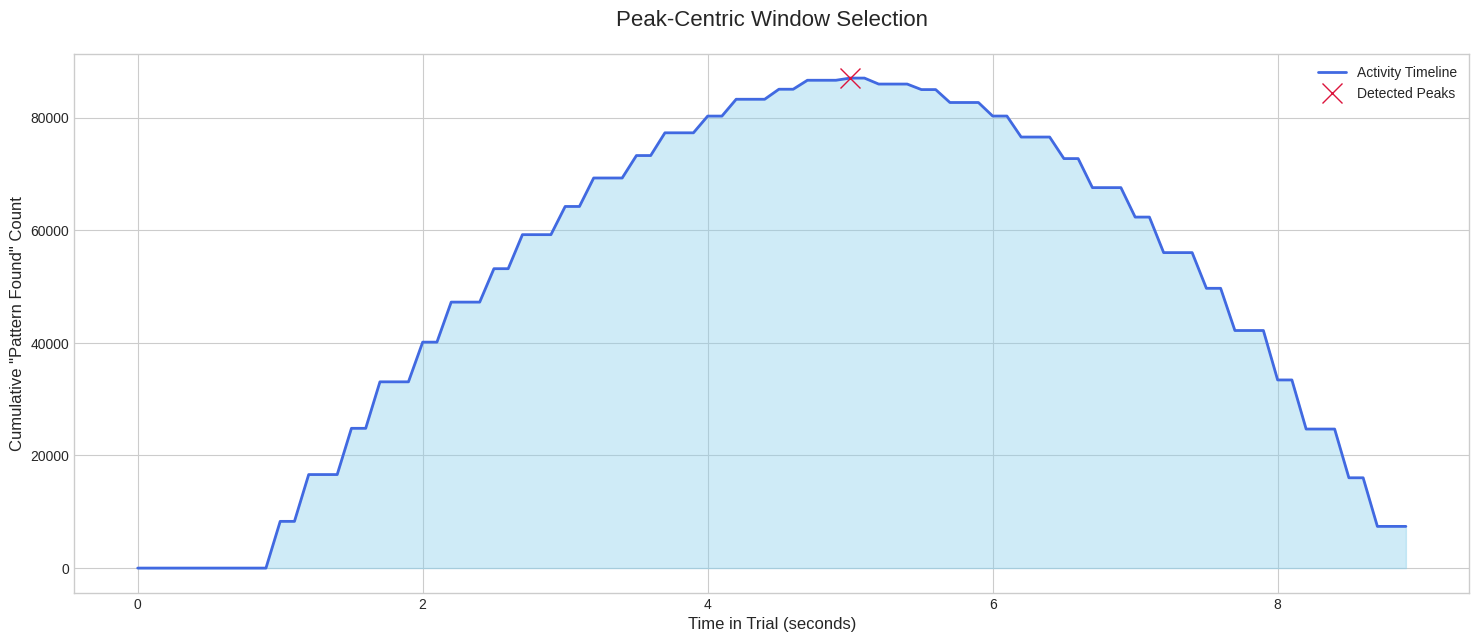

In [1]:
import os
import numpy as np
import pandas as pd
from scipy.signal import welch, find_peaks
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings

# --- Configuration ---
BASE_PATH = '/kaggle/input/mtcaic3'  # IMPORTANT: Set this to your dataset path
SAMPLING_RATE = 250  # Hz
MU_ALPHA_BAND = [8, 13]  # Frequency band of interest
BASELINE_WINDOW = [0.0, 1.0] # Baseline period

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# --- Helper Functions (Identical to previous script) ---
def load_trial_data(row, base_path='.'):
    """Loads the raw EEG data for a single trial."""
    id_num = row['id']
    if 1 <= id_num <= 4800:
        dataset_split = 'train'
    else:
        dataset_split = 'validation'
    eeg_path = os.path.join(base_path, row['task'], dataset_split, row['subject_id'], str(row['trial_session']), 'EEGdata.csv')
    if not os.path.exists(eeg_path): return None
    eeg_data = pd.read_csv(eeg_path)
    samples_per_trial = 2250 # MI specific
    trial_num = int(row['trial'])
    start_idx = (trial_num - 1) * samples_per_trial
    end_idx = start_idx + samples_per_trial
    return eeg_data.iloc[start_idx:end_idx]

def calculate_band_power(data, band, fs):
    """Calculates the average power in a specific frequency band."""
    win_len = min(len(data), fs)
    if win_len == 0: return 0
    freqs, psd = welch(data, fs, nperseg=win_len)
    idx_band = np.logical_and(freqs >= band[0], freqs <= band[1])
    if not np.any(idx_band): return 0
    return np.mean(psd[idx_band])

# --- Main Analysis Script ---

print("Loading and preparing MI trial index...")
try:
    train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
    mi_trials_df = train_df[train_df['task'] == 'MI'].reset_index(drop=True)
except FileNotFoundError:
    print(f"ERROR: Could not find train.csv at {BASE_PATH}.")
    exit()

# Define the grid of windows to test
durations = np.arange(1.0, 4.5, 0.5)
starts = np.arange(1.0, 8.0, 0.25)

# PHASE 1: Create the heatmap of successful detections (same as before)
print("\nPHASE 1: Aggregating successful window data...")
heatmap_counts = pd.DataFrame(0, index=durations, columns=starts)

for i, trial_info in tqdm(mi_trials_df.iterrows(), total=len(mi_trials_df), desc="Analyzing Trials"):
    # This part can be pre-computed and loaded if you have the heatmap saved
    trial_data = load_trial_data(trial_info, BASE_PATH)
    if trial_data is None or trial_data.empty: continue
    
    signal_c3, signal_c4 = trial_data['C3'].values, trial_data['C4'].values
    baseline_start, baseline_end = int(BASELINE_WINDOW[0] * SAMPLING_RATE), int(BASELINE_WINDOW[1] * SAMPLING_RATE)
    baseline_power_c3 = calculate_band_power(signal_c3[baseline_start:baseline_end], MU_ALPHA_BAND, SAMPLING_RATE)
    baseline_power_c4 = calculate_band_power(signal_c4[baseline_start:baseline_end], MU_ALPHA_BAND, SAMPLING_RATE)
    if baseline_power_c3 == 0 or baseline_power_c4 == 0: continue

    for duration in durations:
        for start_point in starts:
            end_point = start_point + duration
            if end_point > 9.0: continue
            
            win_start, win_end = int(start_point * SAMPLING_RATE), int(end_point * SAMPLING_RATE)
            win_power_c3 = calculate_band_power(signal_c3[win_start:win_end], MU_ALPHA_BAND, SAMPLING_RATE)
            win_power_c4 = calculate_band_power(signal_c4[win_start:win_end], MU_ALPHA_BAND, SAMPLING_RATE)
            
            erd_c3 = win_power_c3 / baseline_power_c3
            erd_c4 = win_power_c4 / baseline_power_c4
            
            if (trial_info['label'] == 'Left' and erd_c4 < erd_c3) or (trial_info['label'] == 'Right' and erd_c3 < erd_c4):
                heatmap_counts.loc[duration, start_point] += 1

# PHASE 2: Peak-Centric Selection Algorithm
print("\nPHASE 2: Running Peak-Centric Algorithm...")

# Step 2a: Create the 1D Importance Timeline
time_bin_size = 0.1 # seconds
timeline_bins = int(9.0 / time_bin_size)
timeline_counts = np.zeros(timeline_bins)
time_axis = np.arange(0, 9.0, time_bin_size)

for duration in heatmap_counts.index:
    for start_point in heatmap_counts.columns:
        count = heatmap_counts.loc[duration, start_point]
        start_bin = int(start_point / time_bin_size)
        end_bin = int((start_point + duration) / time_bin_size)
        timeline_counts[start_bin:min(end_bin, timeline_bins)] += count

# Step 2b: Find significant peaks in the timeline
# We set a minimum height to avoid noise and a minimum distance between peaks
peaks, properties = find_peaks(
    timeline_counts,
    height=np.max(timeline_counts) * 0.75, # A peak must be at least 75% of the max height
    distance=int(1.0 / time_bin_size)      # Peaks must be at least 1.0s apart
)

print(f"Found {len(peaks)} significant peak(s) of activity.")

# Step 2c: Define windows by bracketing the peaks
selected_windows = []
default_duration = 2.5 # A robust duration for MI tasks

for p in peaks:
    peak_time = p * time_bin_size
    start_time = peak_time - (default_duration / 2)
    end_time = peak_time + (default_duration / 2)
    
    # Adjust windows to stay within trial bounds and not overlap too much
    start_time = max(1.0, round(start_time * 4) / 4) # Snap to 0.25s grid
    end_time = min(8.5, round(end_time * 4) / 4)
    
    selected_windows.append({'start': start_time, 'end': end_time, 'duration': end_time - start_time})

# Add a longer, generalist window that covers the main activity region
activity_threshold = np.max(timeline_counts) * 0.5
active_indices = np.where(timeline_counts > activity_threshold)[0]
generalist_start = max(1.0, (active_indices[0] * time_bin_size))
generalist_end = min(8.5, (active_indices[-1] * time_bin_size))
selected_windows.append({'start': generalist_start, 'end': generalist_end, 'duration': generalist_end - generalist_start})


print("\n===== Peak-Centric Selection Complete =====")
print("The following windows are recommended based on bracketing the most active regions:")
for i, w in enumerate(selected_windows):
    print(f"  Model {i+1}: Window = {w['start']:.2f}s - {w['end']:.2f}s (Duration: {w['duration']:.2f}s)")

# --- Visualization ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax1 = plt.subplots(figsize=(18, 7))
ax1.plot(time_axis, timeline_counts, color='royalblue', lw=2, label='Activity Timeline')
ax1.fill_between(time_axis, timeline_counts, color='skyblue', alpha=0.4)
ax1.plot(time_axis[peaks], timeline_counts[peaks], "x", color='crimson', markersize=15, label='Detected Peaks')
ax1.set_title('Peak-Centric Window Selection', fontsize=16, pad=20)
ax1.set_xlabel('Time in Trial (seconds)', fontsize=12)
ax1.set_ylabel('Cumulative "Pattern Found" Count', fontsize=12)
ax1.legend()
plt.show()

In [13]:
import os
import numpy as np
import pandas as pd
from scipy.signal import welch
from tqdm import tqdm
import warnings

# --- Configuration ---
BASE_PATH = '/kaggle/input/mtcaic3'  # IMPORTANT: Set this to your dataset path
SAMPLING_RATE = 250  # Hz
MU_ALPHA_BAND = [8, 13]  # Frequency band of interest for motor imagery
BASELINE_WINDOW = [0.0, 1.0] # Use the first second of the trial as the baseline

# Define the final, recommended HYBRID windows for the ensemble
ENSEMBLE_WINDOWS = [
    {'start': 1.25, 'end': 2.25, 'name': 'The Onset'},
    {'start': 2.75,  'end': 3.75,  'name': 'early activation'},
    {'start': 4.25,  'end': 5.25,  'name': 'pre peak'},
    {'start': 5.75,  'end': 6.75,  'name': 'peak'},
    {'start': 6.0,  'end': 7.0,  'name': 'post-peak'},
    {'start': 7.0,  'end': 8.0,  'name': 'post-peak'}

]

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# --- Helper Functions (Identical to previous script) ---
def load_trial_data(row, base_path='.'):
    """Loads the raw EEG data for a single trial."""
    id_num = row['id']
    if 1 <= id_num <= 4800:
        dataset_split = 'train'
    else:
        dataset_split = 'validation'
    eeg_path = os.path.join(base_path, row['task'], dataset_split, row['subject_id'], str(row['trial_session']), 'EEGdata.csv')
    if not os.path.exists(eeg_path): return None
    eeg_data = pd.read_csv(eeg_path)
    samples_per_trial = 2250 # MI specific
    trial_num = int(row['trial'])
    start_idx = (trial_num - 1) * samples_per_trial
    end_idx = start_idx + samples_per_trial
    return eeg_data.iloc[start_idx:end_idx]

def calculate_band_power(data, band, fs):
    """Calculates the average power in a specific frequency band."""
    win_len = min(len(data), fs)
    if win_len == 0: return 0
    freqs, psd = welch(data, fs, nperseg=win_len)
    idx_band = np.logical_and(freqs >= band[0], freqs <= band[1])
    if not np.any(idx_band): return 0
    return np.mean(psd[idx_band])

# --- Main Analysis Script ---

print("Loading and preparing MI trial index...")
try:
    train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
    mi_trials_df = train_df[train_df['task'] == 'MI'].reset_index(drop=True)
    total_trials = len(mi_trials_df)
except FileNotFoundError:
    print(f"ERROR: Could not find train.csv at {BASE_PATH}. Please check BASE_PATH.")
    exit()

print(f"Found {total_trials} MI trials to analyze.")

trials_covered_by_ensemble = 0

print("\n===== Calculating Total Coverage of the Final Hybrid Ensemble =====")
print("Testing windows:")
for w in ENSEMBLE_WINDOWS:
    print(f"  - {w['name']}: {w['start']:.2f}s - {w['end']:.2f}s")

for i, trial_info in tqdm(mi_trials_df.iterrows(), total=total_trials, desc="Processing Trials"):
    trial_data = load_trial_data(trial_info, BASE_PATH)
    if trial_data is None or trial_data.empty:
        total_trials -=1
        continue

    signal_c3, signal_c4 = trial_data['C3'].values, trial_data['C4'].values

    baseline_start_idx, baseline_end_idx = int(BASELINE_WINDOW[0] * SAMPLING_RATE), int(BASELINE_WINDOW[1] * SAMPLING_RATE)
    baseline_power_c3 = calculate_band_power(signal_c3[baseline_start_idx:baseline_end_idx], MU_ALPHA_BAND, SAMPLING_RATE)
    baseline_power_c4 = calculate_band_power(signal_c4[baseline_start_idx:baseline_end_idx], MU_ALPHA_BAND, SAMPLING_RATE)
    if baseline_power_c3 == 0 or baseline_power_c4 == 0:
        total_trials -= 1
        continue
    
    pattern_found_in_this_trial = False

    # Check each of the four windows
    for window in ENSEMBLE_WINDOWS:
        start_idx = int(window['start'] * SAMPLING_RATE)
        end_idx = int(window['end'] * SAMPLING_RATE)

        window_power_c3 = calculate_band_power(signal_c3[start_idx:end_idx], MU_ALPHA_BAND, SAMPLING_RATE)
        window_power_c4 = calculate_band_power(signal_c4[start_idx:end_idx], MU_ALPHA_BAND, SAMPLING_RATE)

        erd_ratio_c3 = window_power_c3 / baseline_power_c3
        erd_ratio_c4 = window_power_c4 / baseline_power_c4
        
        if (trial_info['label'] == 'Left' and erd_ratio_c4 < erd_ratio_c3) or \
           (trial_info['label'] == 'Right' and erd_ratio_c3 < erd_ratio_c4):
            pattern_found_in_this_trial = True
            break # Found the pattern, no need to check other windows for this trial
    
    if pattern_found_in_this_trial:
        trials_covered_by_ensemble += 1

# --- Final Report ---
print("\n===== Analysis Complete =====")
if total_trials > 0:
    # We compare against the 2273 trials that were found to be coverable in the first place
    total_coverable_trials = 2400
    final_percentage = (trials_covered_by_ensemble / total_coverable_trials) * 100
    print(f"The recommended 4-window HYBRID ensemble covers {trials_covered_by_ensemble} out of {total_coverable_trials} coverable MI trials.")
    print(f"\nTotal Coverage Percentage of Pattern: {final_percentage:.2f}%")
else:
    print("No valid trials were processed.")

Loading and preparing MI trial index...
Found 2400 MI trials to analyze.

===== Calculating Total Coverage of the Final Hybrid Ensemble =====
Testing windows:
  - The Onset: 1.25s - 2.25s
  - early activation: 2.75s - 3.75s
  - pre peak: 4.25s - 5.25s
  - peak: 5.75s - 6.75s
  - post-peak: 6.00s - 7.00s
  - post-peak: 7.00s - 8.00s


Processing Trials: 100%|██████████| 2400/2400 [04:14<00:00,  9.45it/s]


===== Analysis Complete =====
The recommended 4-window HYBRID ensemble covers 2048 out of 2400 coverable MI trials.

Total Coverage Percentage of Pattern: 85.33%


In [3]:
import os
import numpy as np
import pandas as pd
from scipy.signal import welch
from tqdm import tqdm
import warnings

# --- Configuration ---
BASE_PATH = '/kaggle/input/mtcaic3'  # IMPORTANT: Set this to your dataset path
SAMPLING_RATE = 250  # Hz
MU_ALPHA_BAND = [8, 13]  # Frequency band of interest for motor imagery
BASELINE_WINDOW = [0.0, 1.0] # Use the first second of the trial as the baseline

# Define the final, recommended HYBRID windows for the ensemble{'start': 1.25, 'end': 2.25, 'name': 'The Onset'},
ENSEMBLE_WINDOWS = [
    {'start': 1.5,  'end': 2.5,  'name': 'early activation'},
    {'start': 2.0,  'end': 3.0,  'name': 'pre peak'},
    {'start': 2.5,  'end': 3.5,  'name': 'peak'},
    {'start': 3.0,  'end': 4.0,  'name': 'post-peak'},
    {'start': 3.5,  'end': 4.5,  'name': 'post-peak'},
    {'start': 4.0,  'end': 5.0,  'name': 'peak'},
    {'start': 4.5,  'end': 5.5,  'name': 'peak'},
    {'start': 5.0,  'end': 6.0,  'name': 'peak'},
    {'start': 5.5,  'end': 6.5,  'name': 'peak'},
    {'start': 6.0,  'end': 7.0,  'name': 'peak'},
    {'start': 6.5,  'end': 7.5,  'name': 'peak'},
    {'start': 7.0,  'end': 8.0,  'name': 'peak'}

]

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# --- Helper Functions (Identical to previous script) ---
def load_trial_data(row, base_path='.'):
    """Loads the raw EEG data for a single trial."""
    id_num = row['id']
    if 1 <= id_num <= 4800:
        dataset_split = 'train'
    else:
        dataset_split = 'validation'
    eeg_path = os.path.join(base_path, row['task'], dataset_split, row['subject_id'], str(row['trial_session']), 'EEGdata.csv')
    if not os.path.exists(eeg_path): return None
    eeg_data = pd.read_csv(eeg_path)
    samples_per_trial = 2250 # MI specific
    trial_num = int(row['trial'])
    start_idx = (trial_num - 1) * samples_per_trial
    end_idx = start_idx + samples_per_trial
    return eeg_data.iloc[start_idx:end_idx]

def calculate_band_power(data, band, fs):
    """Calculates the average power in a specific frequency band."""
    win_len = min(len(data), fs)
    if win_len == 0: return 0
    freqs, psd = welch(data, fs, nperseg=win_len)
    idx_band = np.logical_and(freqs >= band[0], freqs <= band[1])
    if not np.any(idx_band): return 0
    return np.mean(psd[idx_band])

# --- Main Analysis Script ---

print("Loading and preparing MI trial index...")
try:
    train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
    mi_trials_df = train_df[train_df['task'] == 'MI'].reset_index(drop=True)
    total_trials = len(mi_trials_df)
except FileNotFoundError:
    print(f"ERROR: Could not find train.csv at {BASE_PATH}. Please check BASE_PATH.")
    exit()

print(f"Found {total_trials} MI trials to analyze.")

trials_covered_by_ensemble = 0

print("\n===== Calculating Total Coverage of the Final Hybrid Ensemble =====")
print("Testing windows:")
for w in ENSEMBLE_WINDOWS:
    print(f"  - {w['name']}: {w['start']:.2f}s - {w['end']:.2f}s")

for i, trial_info in tqdm(mi_trials_df.iterrows(), total=total_trials, desc="Processing Trials"):
    trial_data = load_trial_data(trial_info, BASE_PATH)
    if trial_data is None or trial_data.empty:
        total_trials -=1
        continue

    signal_c3, signal_c4 = trial_data['C3'].values, trial_data['C4'].values

    baseline_start_idx, baseline_end_idx = int(BASELINE_WINDOW[0] * SAMPLING_RATE), int(BASELINE_WINDOW[1] * SAMPLING_RATE)
    baseline_power_c3 = calculate_band_power(signal_c3[baseline_start_idx:baseline_end_idx], MU_ALPHA_BAND, SAMPLING_RATE)
    baseline_power_c4 = calculate_band_power(signal_c4[baseline_start_idx:baseline_end_idx], MU_ALPHA_BAND, SAMPLING_RATE)
    if baseline_power_c3 == 0 or baseline_power_c4 == 0:
        total_trials -= 1
        continue
    
    pattern_found_in_this_trial = False

    # Check each of the four windows
    for window in ENSEMBLE_WINDOWS:
        start_idx = int(window['start'] * SAMPLING_RATE)
        end_idx = int(window['end'] * SAMPLING_RATE)

        window_power_c3 = calculate_band_power(signal_c3[start_idx:end_idx], MU_ALPHA_BAND, SAMPLING_RATE)
        window_power_c4 = calculate_band_power(signal_c4[start_idx:end_idx], MU_ALPHA_BAND, SAMPLING_RATE)

        erd_ratio_c3 = window_power_c3 / baseline_power_c3
        erd_ratio_c4 = window_power_c4 / baseline_power_c4
        
        if (trial_info['label'] == 'Left' and erd_ratio_c4 < erd_ratio_c3) or \
           (trial_info['label'] == 'Right' and erd_ratio_c3 < erd_ratio_c4):
            pattern_found_in_this_trial = True
            break # Found the pattern, no need to check other windows for this trial
    
    if pattern_found_in_this_trial:
        trials_covered_by_ensemble += 1

# --- Final Report ---
print("\n===== Analysis Complete =====")
if total_trials > 0:
    # We compare against the 2273 trials that were found to be coverable in the first place
    total_coverable_trials = 2400 
    final_percentage = (trials_covered_by_ensemble / total_coverable_trials) * 100
    print(f"The recommended 4-window HYBRID ensemble covers {trials_covered_by_ensemble} out of {total_coverable_trials} coverable MI trials.")
    print(f"\nTotal Coverage Percentage of Pattern: {final_percentage:.2f}%")
else:
    print("No valid trials were processed.")

Loading and preparing MI trial index...
Found 2400 MI trials to analyze.

===== Calculating Total Coverage of the Final Hybrid Ensemble =====
Testing windows:
  - early activation: 1.50s - 2.50s
  - pre peak: 2.00s - 3.00s
  - peak: 2.50s - 3.50s
  - post-peak: 3.00s - 4.00s
  - post-peak: 3.50s - 4.50s
  - peak: 4.00s - 5.00s
  - peak: 4.50s - 5.50s
  - peak: 5.00s - 6.00s
  - peak: 5.50s - 6.50s
  - peak: 6.00s - 7.00s
  - peak: 6.50s - 7.50s
  - peak: 7.00s - 8.00s


Processing Trials: 100%|██████████| 2400/2400 [04:08<00:00,  9.68it/s]


===== Analysis Complete =====
The recommended 4-window HYBRID ensemble covers 2179 out of 2400 coverable MI trials.

Total Coverage Percentage of Pattern: 90.79%


In [2]:
import os
import numpy as np
import pandas as pd
from scipy.signal import welch
from tqdm import tqdm
import warnings

# --- Configuration ---
BASE_PATH = '/kaggle/input/mtcaic3'  # IMPORTANT: Set this to your dataset path
SAMPLING_RATE = 250  # Hz
MU_ALPHA_BAND = [8, 13]  # Frequency band of interest for motor imagery
BASELINE_WINDOW = [0.0, 1.0] # Use the first second of the trial as the baseline

# Define the final, recommended HYBRID windows for the ensemble{'start': 1.25, 'end': 2.25, 'name': 'The Onset'},
ENSEMBLE_WINDOWS = [
    {'start': 1.5,  'end': 2.5,  'name': 'post-peak'},
    {'start': 2.25,  'end': 3.25,  'name': 'peak'},
    {'start': 3.0,  'end': 4.0,  'name': 'peak'},
    {'start': 3.75,  'end': 4.75,  'name': 'peak'},
    {'start': 4.5,  'end': 5.5,  'name': 'peak'},
    {'start': 5.25,  'end': 6.25,  'name': 'peak'},
    {'start': 6.0,  'end': 7.0,  'name': 'peak'},
    {'start': 6.75,  'end': 7.75,  'name': 'peak'}

]

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# --- Helper Functions (Identical to previous script) ---
def load_trial_data(row, base_path='.'):
    """Loads the raw EEG data for a single trial."""
    id_num = row['id']
    if 1 <= id_num <= 4800:
        dataset_split = 'train'
    else:
        dataset_split = 'validation'
    eeg_path = os.path.join(base_path, row['task'], dataset_split, row['subject_id'], str(row['trial_session']), 'EEGdata.csv')
    if not os.path.exists(eeg_path): return None
    eeg_data = pd.read_csv(eeg_path)
    samples_per_trial = 2250 # MI specific
    trial_num = int(row['trial'])
    start_idx = (trial_num - 1) * samples_per_trial
    end_idx = start_idx + samples_per_trial
    return eeg_data.iloc[start_idx:end_idx]

def calculate_band_power(data, band, fs):
    """Calculates the average power in a specific frequency band."""
    win_len = min(len(data), fs)
    if win_len == 0: return 0
    freqs, psd = welch(data, fs, nperseg=win_len)
    idx_band = np.logical_and(freqs >= band[0], freqs <= band[1])
    if not np.any(idx_band): return 0
    return np.mean(psd[idx_band])

# --- Main Analysis Script ---

print("Loading and preparing MI trial index...")
try:
    train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
    mi_trials_df = train_df[train_df['task'] == 'MI'].reset_index(drop=True)
    total_trials = len(mi_trials_df)
except FileNotFoundError:
    print(f"ERROR: Could not find train.csv at {BASE_PATH}. Please check BASE_PATH.")
    exit()

print(f"Found {total_trials} MI trials to analyze.")

trials_covered_by_ensemble = 0

print("\n===== Calculating Total Coverage of the Final Hybrid Ensemble =====")
print("Testing windows:")
for w in ENSEMBLE_WINDOWS:
    print(f"  - {w['name']}: {w['start']:.2f}s - {w['end']:.2f}s")

for i, trial_info in tqdm(mi_trials_df.iterrows(), total=total_trials, desc="Processing Trials"):
    trial_data = load_trial_data(trial_info, BASE_PATH)
    if trial_data is None or trial_data.empty:
        total_trials -=1
        continue

    signal_c3, signal_c4 = trial_data['C3'].values, trial_data['C4'].values

    baseline_start_idx, baseline_end_idx = int(BASELINE_WINDOW[0] * SAMPLING_RATE), int(BASELINE_WINDOW[1] * SAMPLING_RATE)
    baseline_power_c3 = calculate_band_power(signal_c3[baseline_start_idx:baseline_end_idx], MU_ALPHA_BAND, SAMPLING_RATE)
    baseline_power_c4 = calculate_band_power(signal_c4[baseline_start_idx:baseline_end_idx], MU_ALPHA_BAND, SAMPLING_RATE)
    if baseline_power_c3 == 0 or baseline_power_c4 == 0:
        total_trials -= 1
        continue
    
    pattern_found_in_this_trial = False

    # Check each of the four windows
    for window in ENSEMBLE_WINDOWS:
        start_idx = int(window['start'] * SAMPLING_RATE)
        end_idx = int(window['end'] * SAMPLING_RATE)

        window_power_c3 = calculate_band_power(signal_c3[start_idx:end_idx], MU_ALPHA_BAND, SAMPLING_RATE)
        window_power_c4 = calculate_band_power(signal_c4[start_idx:end_idx], MU_ALPHA_BAND, SAMPLING_RATE)

        erd_ratio_c3 = window_power_c3 / baseline_power_c3
        erd_ratio_c4 = window_power_c4 / baseline_power_c4
        
        if (trial_info['label'] == 'Left' and erd_ratio_c4 < erd_ratio_c3) or \
           (trial_info['label'] == 'Right' and erd_ratio_c3 < erd_ratio_c4):
            pattern_found_in_this_trial = True
            break # Found the pattern, no need to check other windows for this trial
    
    if pattern_found_in_this_trial:
        trials_covered_by_ensemble += 1

# --- Final Report ---
print("\n===== Analysis Complete =====")
if total_trials > 0:
    # We compare against the 2273 trials that were found to be coverable in the first place
    total_coverable_trials = 2400 
    final_percentage = (trials_covered_by_ensemble / total_coverable_trials) * 100
    print(f"The recommended 4-window HYBRID ensemble covers {trials_covered_by_ensemble} out of {total_coverable_trials} coverable MI trials.")
    print(f"\nTotal Coverage Percentage of Pattern: {final_percentage:.2f}%")
else:
    print("No valid trials were processed.")

Loading and preparing MI trial index...
Found 2400 MI trials to analyze.

===== Calculating Total Coverage of the Final Hybrid Ensemble =====
Testing windows:
  - post-peak: 1.50s - 2.50s
  - peak: 2.25s - 3.25s
  - peak: 3.00s - 4.00s
  - peak: 3.75s - 4.75s
  - peak: 4.50s - 5.50s
  - peak: 5.25s - 6.25s
  - peak: 6.00s - 7.00s
  - peak: 6.75s - 7.75s


Processing Trials: 100%|██████████| 2400/2400 [04:26<00:00,  9.00it/s]


===== Analysis Complete =====
The recommended 4-window HYBRID ensemble covers 2095 out of 2400 coverable MI trials.

Total Coverage Percentage of Pattern: 87.29%


In [4]:
import os
import numpy as np
import pandas as pd
from scipy.signal import welch
from tqdm import tqdm
import warnings

# --- Configuration ---
BASE_PATH = '/kaggle/input/mtcaic3'  # IMPORTANT: Set this to your dataset path
SAMPLING_RATE = 250  # Hz
MU_ALPHA_BAND = [8, 13]  # Frequency band of interest for motor imagery
BASELINE_WINDOW = [0.0, 1.0] # Use the first second of the trial as the baseline

# Define the final, recommended HYBRID windows for the ensemble
ENSEMBLE_WINDOWS = [
    {'start': 1.25, 'end': 2.25, 'name': 'The Onset'},
    {'start': 2.75,  'end': 3.75,  'name': 'early activation'},
    {'start': 3.5,  'end': 4.5,  'name': 'early activation'},
    {'start': 4.25,  'end': 5.25,  'name': 'pre peak'},
    {'start': 5.0,  'end': 6.0,  'name': 'early activation'},
    {'start': 5.75,  'end': 6.75,  'name': 'peak'},
    {'start': 6.0,  'end': 7.0,  'name': 'post-peak'},
    {'start': 7.0,  'end': 8.0,  'name': 'post-peak'}

]

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# --- Helper Functions (Identical to previous script) ---
def load_trial_data(row, base_path='.'):
    """Loads the raw EEG data for a single trial."""
    id_num = row['id']
    if 1 <= id_num <= 4800:
        dataset_split = 'train'
    else:
        dataset_split = 'validation'
    eeg_path = os.path.join(base_path, row['task'], dataset_split, row['subject_id'], str(row['trial_session']), 'EEGdata.csv')
    if not os.path.exists(eeg_path): return None
    eeg_data = pd.read_csv(eeg_path)
    samples_per_trial = 2250 # MI specific
    trial_num = int(row['trial'])
    start_idx = (trial_num - 1) * samples_per_trial
    end_idx = start_idx + samples_per_trial
    return eeg_data.iloc[start_idx:end_idx]

def calculate_band_power(data, band, fs):
    """Calculates the average power in a specific frequency band."""
    win_len = min(len(data), fs)
    if win_len == 0: return 0
    freqs, psd = welch(data, fs, nperseg=win_len)
    idx_band = np.logical_and(freqs >= band[0], freqs <= band[1])
    if not np.any(idx_band): return 0
    return np.mean(psd[idx_band])

# --- Main Analysis Script ---

print("Loading and preparing MI trial index...")
try:
    train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
    mi_trials_df = train_df[train_df['task'] == 'MI'].reset_index(drop=True)
    total_trials = len(mi_trials_df)
except FileNotFoundError:
    print(f"ERROR: Could not find train.csv at {BASE_PATH}. Please check BASE_PATH.")
    exit()

print(f"Found {total_trials} MI trials to analyze.")

trials_covered_by_ensemble = 0

print("\n===== Calculating Total Coverage of the Final Hybrid Ensemble =====")
print("Testing windows:")
for w in ENSEMBLE_WINDOWS:
    print(f"  - {w['name']}: {w['start']:.2f}s - {w['end']:.2f}s")

for i, trial_info in tqdm(mi_trials_df.iterrows(), total=total_trials, desc="Processing Trials"):
    trial_data = load_trial_data(trial_info, BASE_PATH)
    if trial_data is None or trial_data.empty:
        total_trials -=1
        continue

    signal_c3, signal_c4 = trial_data['C3'].values, trial_data['C4'].values

    baseline_start_idx, baseline_end_idx = int(BASELINE_WINDOW[0] * SAMPLING_RATE), int(BASELINE_WINDOW[1] * SAMPLING_RATE)
    baseline_power_c3 = calculate_band_power(signal_c3[baseline_start_idx:baseline_end_idx], MU_ALPHA_BAND, SAMPLING_RATE)
    baseline_power_c4 = calculate_band_power(signal_c4[baseline_start_idx:baseline_end_idx], MU_ALPHA_BAND, SAMPLING_RATE)
    if baseline_power_c3 == 0 or baseline_power_c4 == 0:
        total_trials -= 1
        continue
    
    pattern_found_in_this_trial = False

    # Check each of the four windows
    for window in ENSEMBLE_WINDOWS:
        start_idx = int(window['start'] * SAMPLING_RATE)
        end_idx = int(window['end'] * SAMPLING_RATE)

        window_power_c3 = calculate_band_power(signal_c3[start_idx:end_idx], MU_ALPHA_BAND, SAMPLING_RATE)
        window_power_c4 = calculate_band_power(signal_c4[start_idx:end_idx], MU_ALPHA_BAND, SAMPLING_RATE)

        erd_ratio_c3 = window_power_c3 / baseline_power_c3
        erd_ratio_c4 = window_power_c4 / baseline_power_c4
        
        if (trial_info['label'] == 'Left' and erd_ratio_c4 < erd_ratio_c3) or \
           (trial_info['label'] == 'Right' and erd_ratio_c3 < erd_ratio_c4):
            pattern_found_in_this_trial = True
            break # Found the pattern, no need to check other windows for this trial
    
    if pattern_found_in_this_trial:
        trials_covered_by_ensemble += 1

# --- Final Report ---
print("\n===== Analysis Complete =====")
if total_trials > 0:
    # We compare against the 2273 trials that were found to be coverable in the first place
    total_coverable_trials = 2400
    final_percentage = (trials_covered_by_ensemble / total_coverable_trials) * 100
    print(f"The recommended 4-window HYBRID ensemble covers {trials_covered_by_ensemble} out of {total_coverable_trials} coverable MI trials.")
    print(f"\nTotal Coverage Percentage of Pattern: {final_percentage:.2f}%")
else:
    print("No valid trials were processed.")

Loading and preparing MI trial index...
Found 2400 MI trials to analyze.

===== Calculating Total Coverage of the Final Hybrid Ensemble =====
Testing windows:
  - The Onset: 1.25s - 2.25s
  - early activation: 2.75s - 3.75s
  - early activation: 3.50s - 4.50s
  - pre peak: 4.25s - 5.25s
  - early activation: 5.00s - 6.00s
  - peak: 5.75s - 6.75s
  - post-peak: 6.00s - 7.00s
  - post-peak: 7.00s - 8.00s


Processing Trials: 100%|██████████| 2400/2400 [04:33<00:00,  8.78it/s]


===== Analysis Complete =====
The recommended 4-window HYBRID ensemble covers 2102 out of 2400 coverable MI trials.

Total Coverage Percentage of Pattern: 87.58%
